<a id='TOC'></a>

# Table of contents

- [Introduction and preparation](#intro)
    - [Data Cleaning](#cleaning)
    - [Visualizations](#visualizations)
    - [Feature Engineering](#ft_engineering)
- [Modeling and Classification (flat)](#modeling)
    - [Initial model trials](#initial)
    - [Probability tiers](#tiers)
- [Hierarchical classification](#hierarchical)
    - [Frequency-based](#frequency)
    - [Feature-based](#feature-based)
    - [Cluster-based](#cluster-based)
    - [As boosting](#boosting)
- [Final optimal model](#final-model)
- [Conclusions](#conclusions)
    - [Works Cited](#works-cited)
    - [Appendix](#appendix)

<a id='intro'></a>
# Introduction


### The problem
The <a href="http://www.start.umd.edu/gtd/">Global Terrorism Database</a> is a database of all 180,691 reliably recorded acts of terror since 1970.  The data has been collected, cleaned, and curated with the help of various grants and currently resides at the University of Maryland.  In this project, I'll be trying to attribute responsibility for the 46% of these acts of terrorism that are currently unattributed.

This problem presents a number of challenges: 
- the dataset is large, many-featured and strewn with nulls (requires extensive cleaning)
- the data is mixed-type with some categorical and even unstructured data
- the training set of attributed acts differs from the real, untestable test set of unattributed data

But there's one problem in particular that will define this project: there are 3536 distinct categorical values of the target feature.  This places constraints on both our accuracy and our computational feasibility.

### Approaches
My first steps here will be some pretty extensive data cleaning, data examination, and preliminary feature engineering.  After that, I'll explore several different strategies for building a model.  

The ideal approach to a problem with this many target categories would be hierarchical classification, in which a series of submodels are trained to predict successive levels of a hierarchical classification of the target feature (e.g., schools, then departments, then courses), with each prediction utilizing the previous (higher-level) set of predictions.  This sort of model has several advantages.  For one thing, it can achieve increased accuracy and decreased computational cost, since each model only has to predict among the subclasses of the subcategory it is operating on (similar in principle to binary search).  For another, it allows increased transparency: the user can view the successive levels of an example's classification, and the model can even leave an example's classification short of the most specific level if the confidence level is too low.

This case is missing one usual ingredient for such a scheme, though: we don't a hierarchical classification for the terror-perpetrating groups in this dataset. It would be possible to build one from existing incident features, but this would amount to just feature-segmented prediction.  Ideally, we would do extensive research to catalogue the size, ideology, history, nationality, and funding sources of each group.  But this would take more time than I can afford.

Fortunately, there are a number of ways to approximate this approach.  First, I'll try flat classification (no tiering) on subsets of the data as a benchmark.  Then I'll try four different hierarchical or segmented approaches:
1. <b>frequency-based segmented classification:</b> Train a classifier to predict the frequency tier of the data (top 20 most prolific groups, top 50, etc).  Segment the test examples accordingly and train a model on each segment.  The models should be able to achieve a high degree of accuracy on the higher tiers, and parameters can be tweaked to squeeze the most out of the lower tiers (which comprise a small minority of the total data).
2. <b>feature-based segmented classification:</b> Use the same principle, but this time segment the data based on region of the world, and perhaps a time segment as well (smaller clusters of countriers could also be used).  Attacks in Sub-Saharan Africa will only have to be classified among groups with recorded attacks in Sub-Saharan Africa.  This should reduce the number of categories for each predictor by an average 90%.
3. <b>cluster-based hierarchical classification:</b> Group the data by attributed group to generate a profile for each group.  Cluster the groups (probably KNN, Ward agglomerative, or HDBSCAN).  Train a first model to first predict the cluster label of the group.  Then train a second to predict the group from within the groups of that cluster label.  Multiply the probability of the second model by the probability of the first to get an accurate overall probability.  This can be used recursively (ideally with a hierarchical clustering like Ward or HDBSCAN) to produce a multi-tiered hierarchical classification model.
4. <b>quasi-hierarchical (boosted) classification:</b> Run frequency-tier prediction and one or more clustering methods on the data.  Include predicted frequency tier and predicted cluster label(s) as features (a form of boosting).  Let the main classification algorithm sort out how to use these in conjunction with the original features.

Any of these algorithms could prove quite effective.  The frequency-based and quasi-hierarchical options (#1 and #4) will probably be the simplest to implement.  It's hard to predict ahead of time which will be more effective - which is why we need to try at least a sketch of all four.

Each of these approaches can be executed using a variety of classification models.  Given the size and nature of the data, though, the models will need to be non-linear and pretty fast/scalable.  Ability to handle nulls directly is also a plus.  Based on these criteria, the main models I'll use will be:
- <b>Naive Bayes:</b> Simple, fast, and non-linear. But this comes with downsides: not all these features are independent, and they have different types of distributions (frustratingly, slkearn doesn't allow mixed-distribution NB classifiers, so you have to assemble them yourself, which is a little complicated).
- <b>KNN Classifier:</b> Also simple, fast, and non-linear.  I doubt this will be as accurate, but given that I'll be trying clustering anyway, it seems worth a quick try.
- <b>Decision tree:</b> Simple, fast, and non-linear - but prone to overfitting.  There are some ways to counteract this, though, and it's highly interpretable.  A natural conceptual fit with hierarchical classification.
- <b>LightGBM:</b> This model is not as simple as the others, but it's non-linear, highly optimized, and generally very accurate.  It's a gradient-boosted-tree model similar to xgboost (or the very recent catboost), but it tends to run almost twice as fast due to selecting features for splits by node rather than by level.  (It's also a convenient choice because it's the model I've worked the most with.)

An SVM could also be effective for accuracy, but it is far, far slower than the models listed above.  In my limited experience, it's also frequently outperformed by boosted tree models like xgboost or lightGBM.  A neural net could also prove useful here, especially for trying one-shot learning on the long tail of singleton classes (groups responsible for only one incident), but the number of classes could prove computationally difficult, or at least necessitate using hierarchical softmax.

### Evaluation
Naturally there is no way of checking this model's predictions on the unattributed attacks – so I'll be sequestering some of the attributed attacks as dev and test sets and checking the predictions against the actual attributions.

Throughout this project I'll mostly be using plain old accuracy for my evaluation metric.  I'll also take a look at F1-score (macro), but because of the large number of single-instance classes (almost half), this won't be a very good indicator of overall accuracy.  If time allows, it may also be worth looking at a multiclass-modified AUROC score.

### Goals
It's hard to set a preliminary accuracy goal for a new sort of problem like this - especially since there's no way to truly check accuracy for our predictions for the unattributed incidents in the dataset.  We can at least test consistency, though: so one of my goals will be to create a stable and consistent predictive model over the unattributed incidents.  <a href="https://www.researchgate.net/publication/268445148_Terrorist_Group_Prediction_Using_Data_Classification">A 2014 paper published over this dataset</a> using an ensemble method was able to achieve a 6.64% error rate, but that was only predicting attacks by the top six most prolific groups -- which entirely avoids the main challenge of this dataset.  My goal would probably be to use hierarchical classifying to predict roughly three quarters of the attacks at 95% confidence, and for the remaining quarter be able to supply three possible attributions for each attack, which together average at least 90% accuracy. 


<a id='cleaning'></a>

# Load and clean
[back to table of contents](#TOC)


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

In [3]:
gtd_raw_df = pd.read_csv('globalterrorismdb_0718dist.csv', low_memory=False)
gtd_raw_df.shape

(181691, 135)

In [4]:
gtd_raw_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [5]:
gtd_raw_df.dtypes.value_counts()

object     58
float64    55
int64      22
dtype: int64

In [ ]:
# output cleared for sake of reader
print('OVER HALF NULLS:')
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if null_counts[col] > 100000:
        print(col + ":", null_counts[col])

print('\nMANY NULLS:')
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if 100000 >= null_counts[col] > 5000:
        print(col + ":", null_counts[col])

print('\nA FEW NULLS:')        
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if 5000 >= null_counts[col] > 0:
        print(col + ":", null_counts[col])
        
print('\nNO NULLS:')        
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if null_counts[col] == 0:
        print(col)

First we'll do the general-purpose cleaning:

In [4]:
gtd_df = gtd_raw_df.copy()

# drop the 6 rows with 'specificity' nulls - these should be impossible, since 'unknown' is included
gtd_df.dropna(subset=['specificity'], inplace=True)

# 'compclaim' is corrupted: despite having 'no' and 'unknown' options, it's overwhelmingly null with no explanation
gtd_df.drop('compclaim', axis=1, inplace=True)

# for some columns, -9 purely indicates 'unknown' and is precisely the same as Nan
gtd_df['claimed'] = gtd_df.claimed.replace(-9, np.nan)
gtd_df['ransom'] = gtd_df.ransom.replace(-9, np.nan)
gtd_df['ishostkid'] = gtd_df.ishostkid.replace(-9, np.nan)
gtd_df['doubtterr'] = gtd_df.doubtterr.replace(-9, np.nan)
gtd_df['nperps'] = gtd_df.nperps.replace(-99, np.nan)
gtd_df['nperpcap'] = gtd_df.nperpcap.replace(-99, np.nan)

# 20 unknown months are entered as 0s
gtd_df['imonth'] = gtd_df.imonth.replace(0, np.nan)

# drop numerical category codes for categorical string variables (redundant)
numerical_codes = [
    'natlty1',
    'region',
    'country',
    'attacktype1',
    'attacktype2',
    'attacktype3',
    'targtype1',
    'targtype2',
    'targtype3',
    'targsubtype1',
    'targsubtype2',
    'targsubtype3',
    'weaptype1',
    'weaptype2',
    'weaptype3',
    'weaptype4',
    'weapsubtype1',
    'weapsubtype2',
    'weapsubtype3',
    'weapsubtype4',
    'alternative',
    'hostkidoutcome',
    'propextent',
    'claimmode'
]
gtd_df.drop(numerical_codes, axis=1, inplace=True)

# add total_null_ct column (done after the above so num-coded categorical features aren't counted twice)
gtd_df['total_null_ct'] = gtd_df.isnull().sum(axis=1)

# since there are no iyear nulls, and only 20 imonth nulls, and day of month won't likely be useful,
# we can drop approxdate altogether:
gtd_df.drop('approxdate', axis=1, inplace=True)

# fill nulls in alternative_txt (coded alt explanation, e.g. State Actors, for doubted cases)
# with new category 'None'
gtd_df['alternative_txt'] = gtd_df['alternative_txt'].fillna('None')

# for instances with no longitude or latitude, read in the central longitude and latitude 
# of the country of occurrence (from an external datasheet), but flag as approximate
gtd_df['coordinates_are_approx'] = gtd_df.longitude.isnull()
coordinates_df = pd.read_csv('country_coordinates2.csv')[['name','latitude','longitude']]
coordinates_df.rename(columns={'name':'country_txt','latitude':'latitude2','longitude':'longitude2'}, inplace=True)
gtd_df = gtd_df.merge(coordinates_df, on='country_txt', how='left')
gtd_df['longitude'] = gtd_df.longitude.fillna(gtd_df.longitude2)
gtd_df['latitude'] = gtd_df.latitude.fillna(gtd_df.latitude2)
gtd_df.drop(['latitude2', 'longitude2'], axis=1, inplace=True)
# for reasons unclear, the one 'St. Kitts and Nevis' null won't fill even when the name is directly copied and pasted
# into this spreadsheet.  We'll manually fill it here:
gtd_df.at[59662,'latitude'] = 17.357822
gtd_df.at[59662,'longitude'] = -62.783998
gtd_df.isnull().sum().sum()

# boolean-ize and drop columns that are overwhelmingly null and have many categories:
gtd_df['has_second_attacktype'] = ~gtd_df.attacktype2_txt.isnull()
gtd_df['is_related'] = ~gtd_df.related.isnull()
gtd_df.drop(['related','attacktype2_txt', 'attacktype3_txt'], axis=1, inplace=True)

# combine nhours and ndays of hostage situation
gtd_df['nhours'] = gtd_df.nhours + gtd_df.ndays*24
gtd_df.drop('ndays', axis=1, inplace=True)

# convert hostages released to hostages unreleased so that we can fill with 0:
gtd_df['n_unreleased'] = gtd_df['nhostkid'] - gtd_df['nreleased']
gtd_df.drop('nreleased', axis=1, inplace=True)

# fill 0 for hostage-related numbers where no hostages taken
hostage_num_cols = [
    'nhours',
    'nhostkid',
    'nhostkidus',
    'ransomamt',
    'ransomamtus',
    'ransompaid',
    'ransompaidus',
    'n_unreleased'
]
gtd_df[hostage_num_cols] = gtd_df[hostage_num_cols].fillna(0)

# drop sparse & unhelpful secondary / tertiary claim info - which is almost entirely null:
empty_cols = [
    'claim2',
    'claimmode2',
    'claim3',
    'claimmode3',
    'natlty2',
    'natlty3',
    'guncertain2',
    'guncertain3'
]
gtd_df.drop(empty_cols, axis=1, inplace=True)

# fill 'none' for categorical extent of property damage (includes 'unknown' already; blanks are for no damage)
gtd_df['propextent_txt'] = gtd_df['propextent_txt'].fillna('none')

# for now we'll also drop string 'resolution' (date of resolution of extended incident) because it's a unique-valued
# string; we could later convert it to a number-of-days interval
gtd_df.drop('resolution', axis=1, inplace=True)

# drop all other string columns with null counts > 100K, with a few exceptions
significant_though_null_cols = ['motive', 'location', 'propcomment', 'resolution']
for col in gtd_df.select_dtypes('object').columns:
    if gtd_df[col].isnull().sum() > 100000 and col not in significant_though_null_cols:
        gtd_df.drop(col, axis=1, inplace=True)
        
# fix a single wild longitude error   
if gtd_df.loc[17658, 'longitude'] != -86185896.0:
    print("WARNING: index has changed.  Transform longitude for eventid 198212240004")
# accessed by index because pandas won't let you change data by boolean accessing
gtd_df.loc[17658, 'longitude'] = gtd_df.loc[17658, 'longitude'] / -10e5

Then we'll do some additional cleaning for modeling purposes:

In [5]:
gtd_prepped_df = gtd_df.copy()

# *** DEALING WITH TEXT COLUMNS ***

# drop the following columns because they're long strings (unique, not categories)
# we'll save them in a separate dataframe for later feature engineering
text_cols = [
    'summary', #  textual summary of event
    'motive', # reported motive of attack
    'weapdetail',  # additional notes on weapon
    'location', # additional notes on location
    'target1', # name of target
    'scite1', # source citation 1
    'propcomment'
]
text_df = gtd_prepped_df[text_cols]
gtd_prepped_df.drop(text_cols, axis=1, inplace=True)

# *** DEALING WITH HYPERSPECIFIC CATEGORICAL COLUMNS ***

# list categorical columns with too many distinct values for dummying (ranging 100-3000 vals)
# NOTE: 'country_txt' at 205 distinct values, is excepted because of its obvious importance
hyperspecific_cols = [
    'natlty1_txt',      # 210 distinct values, but almost entirely identical to 'country_txt'
    'provstate',        # useful, but 2855 distinct values
    'city',             # useful, but 36672 distinct values
    'targsubtype1_txt', # 112 distinct values, with dwindling tail of value counts
]
# fill their nulls with 'unknown'
for col in hyperspecific_cols:
    gtd_prepped_df[col] = gtd_prepped_df[col].fillna('Unknown')
    
# convert hyperspecific features to the X most common values (X determined by manual dropoff-analysis) or 'other'
def top_n_cats(series, n=10, keep_nulls=False):
    top_n = series.value_counts().index[:n]
    if keep_nulls:
        top_n = list(top_n) + [np.nan]
    return pd.Series([val if val in top_n else 'other' for val in series])   

hyperspecific_tups = [
    ('provstate', 15),
    ('city', 15),
    ('targsubtype1_txt', 20)
]

for tup in hyperspecific_tups:
    gtd_prepped_df[tup[0]+'_common'] = top_n_cats(gtd_prepped_df[tup[0]], n=tup[1])

# we'll save the original columns for later feature engineering etc. before dropping them
hyperspecific_df = gtd_prepped_df[hyperspecific_cols + ['gname']].copy()
gtd_prepped_df.drop(hyperspecific_cols, axis=1, inplace=True)

# *** OTHER MISCELLANEOUS ***

# fill 'weapsubtype1_txt' with 'Unknown' (only 30 categories, so no need to commonize)
gtd_prepped_df['weapsubtype1_txt'] = gtd_prepped_df['weapsubtype1_txt'].fillna('Unknown')

# 'corp1' for name of target org. is like the above columns, but it's alread encapsulated by 'targsubtype1'
# so we'll just drop it
hyperspecific_df['corp1'] = gtd_prepped_df['corp1']
gtd_prepped_df.drop('corp1', axis=1, inplace=True)

And finally, we'll do some additional imputing to create a null-less version of our data (necessary for algorithms like sklearn's that can't handle nulls):

In [6]:
gtd_filled_df = gtd_prepped_df.copy()

# fill month with most common month (May)
gtd_filled_df['imonth'] = gtd_filled_df['imonth'].fillna(5)

# fill 'guncertain' with 1 (means attributed group isn't a certain attribution)
gtd_filled_df['guncertain1'] = gtd_filled_df['guncertain1'].fillna(1)

# median-impute casualties - they're only left blank if there is evidence of some,
# (so it's non-zero), but there's insufficient evidence to give a number
casualty_cols = [
    'nkill',
    'nkillus',
    'nkillter',
    'nwound',
    'nwoundus',
    'nwoundte'
]
for col in casualty_cols:
    gtd_filled_df[col] = gtd_filled_df[col].fillna(gtd_filled_df[gtd_filled_df[col] > 0][col].median())

# fill flags with 0 where unmarked probably means no:
flag_vars = ['multiple', 'claimed', 'ransom', 'doubtterr', 'ishostkid']
gtd_filled_df[flag_vars] = gtd_filled_df[flag_vars].fillna(0)

# fill propvalue with median prop damage for cases where there was prop damage
gtd_filled_df['propvalue'] = gtd_filled_df['propvalue'].fillna(gtd_filled_df[gtd_filled_df.propvalue > 0].propvalue.median())
gtd_filled_df['propvalue'] = gtd_filled_df['propvalue'] * gtd_filled_df['property'].replace(-9, 0)

# num perpetrators would be useful, but it's overwhelmingly null and there's no good way to impute
gtd_filled_df.drop(['nperps', 'nperpcap'], axis=1, inplace=True)

# confirm that we have no nulls whatsoever remaining:
gtd_filled_df.isnull().sum().sum()

0

The upshot of all this is that we now have five dataframes to work with:
- `gtd_df`: our primary, cleaned-up dataframe (70 columns)
- `gtd_prepped_df`: a version of the main dataframe prepped for general modeling purposes (60 columns)
- `gtd_filled_df`: a version of the prepped dataframe with all nulls imputed or feature-dropped (58 columns)
- `text_df`: columns with long, unique text content for later processing (8 columns)
- `hyperspecific_df`: columns with too many categories for dummying that could be of use later (3 columns)

Note that all of these versions have the same number of examples in the same order.  This means that we can easily feature-engineer and concatenate later as needed.

<a id='visualizations'></a>

# Exploring the Data
[back to table of contents](#TOC)

We'll begin by investigating some basic statistics and plots for our data, with particular attention to our target variable `gname` (the name of the group that perpetrated the attack). We'll begin with general investigation, and then move on to noting differences between the attributed and unattributed attacks.

### Basic stats

In [19]:
all_groups = gtd_df.gname.value_counts().index[1:] # starting at 1 omits 'Unknown'
num_groups = len(all_groups)
num_singletons = sum(gtd_df.gname.value_counts()==1)
singleton_groups = all_groups[-num_singletons:]
non_singleton_groups = all_groups[:num_singletons]

# calculate number of attacks where we don't know the perpetrating group
pct_unattributed = round(sum( gtd_df.gname=='Unknown') / len(gtd_df.gname) *100)

print("Number of total groups:", num_groups) # -1 because 'Unknown' is a category
print("Number of groups with only one attributed attack:", num_singletons)
print("Number of groups with at least two attributed attacks:", sum(gtd_df.gname.value_counts()>1) -1)
print("Number of groups with at least ten attributed attacks:", sum(gtd_df.gname.value_counts()>9) -1)
print("\nNumber of unattributed attacks:", 
      sum(gtd_df.gname=='Unknown'), 
      "({}% of dataset)".format(pct_unattributed) )

Number of total groups: 3536
Number of groups with only one attributed attack: 1711
Number of groups with at least two attributed attacks: 1825
Number of groups with at least ten attributed attacks: 591

Number of unattributed attacks: 82780 (46% of dataset)


In [20]:
print(gtd_df.gname.value_counts()[1:11])

Taliban                                             7477
Islamic State of Iraq and the Levant (ISIL)         5613
Shining Path (SL)                                   4555
Farabundo Marti National Liberation Front (FMLN)    3351
Al-Shabaab                                          3287
New People's Army (NPA)                             2772
Irish Republican Army (IRA)                         2671
Revolutionary Armed Forces of Colombia (FARC)       2487
Boko Haram                                          2418
Kurdistan Workers' Party (PKK)                      2310
Name: gname, dtype: int64


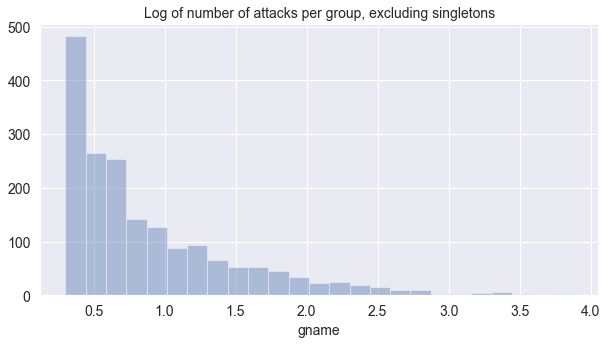

In [11]:
plt.figure(figsize=(10,5))
sns.distplot(np.log10(gtd_df.gname.value_counts()[1:1826]), kde=False)
plt.title("Log of number of attacks per group, excluding singletons")
plt.show()

We can see here that the prolificity of groups (how many attacks each perpetrates) drops off very steeply: even the log distribution looks like an exponential (or possibly Poisson) distribution.  The 30 most prolific grouups (0.8% of all groups) perpetrated over half of the attributed attacks.  Practically, this indicates that a majority of attacks may be fairly easy to attribute (since they belong to the prolific minority), but the long tail of attacks by non-prolific groups will be extremely difficult.

### General plots

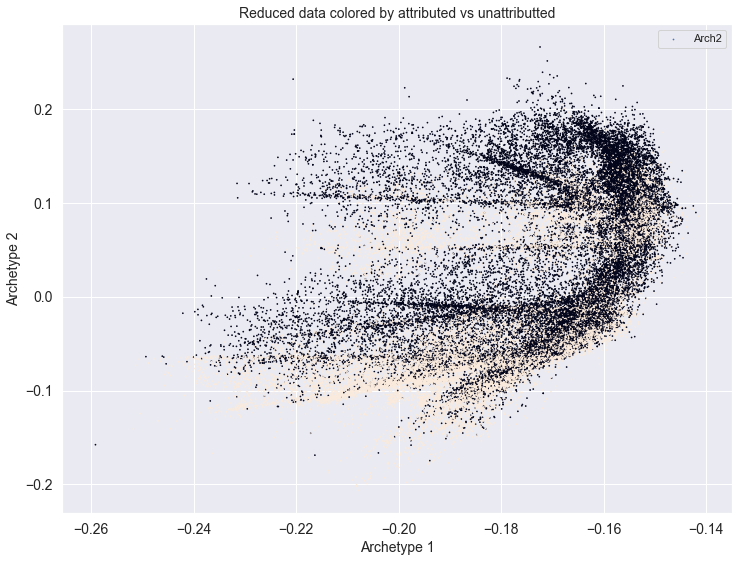

In [10]:
# reload feature-reduced data (method shown later in the notebook)
glrm_vis_df = pd.read_csv('glrm_vis.csv', index_col=0)
plot_df = pd.concat([glrm_vis_df, gtd_df.gname=='Unknown'], axis=1).sample(frac=0.3)
plot_df = plot_df[plot_df.Arch1>-0.3] # cuts off seven or eight outliers for sake of zoom

plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

plt.figure(figsize=(12,9))
plt.scatter(plot_df.Arch1, plot_df.Arch2, c=plot_df.gname, s=0.5)
plt.xlabel('Archetype 1')
plt.ylabel('Archetype 2')
plt.title('Reduced data colored by attributed vs unattributted')
plt.legend()
plt.show()

We can see here that while this data displays no clear and obvious clusters or linearity, it contains definite patterns.  There are also some perceptible differences between attributed and unattributed incidents.

Now let's take a look at the perpetrating groups:

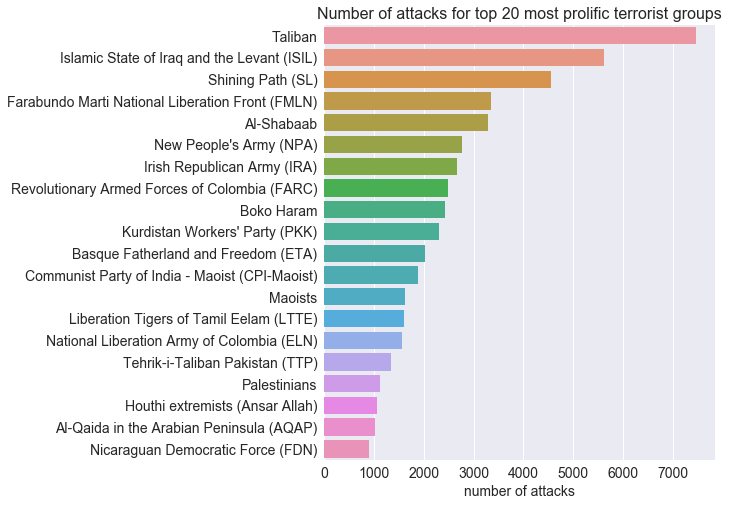

In [107]:
plt.rc('axes', titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

plt.figure(figsize=(7,8))
y = gtd_df.gname.value_counts().index[1:21]
x = gtd_df.gname.value_counts()[1:21]
sns.barplot(x, y)
plt.xlabel('number of attacks')
plt.title("Number of attacks for top 20 most prolific terrorist groups")
plt.show()

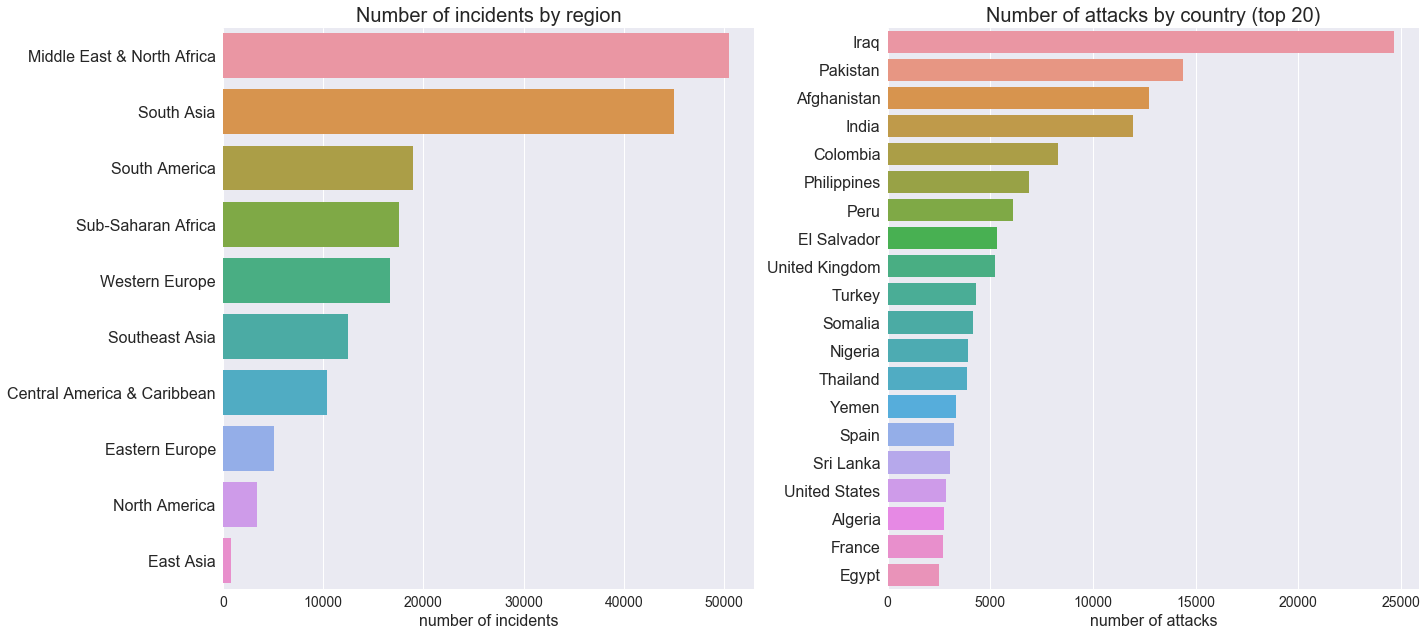

In [110]:
plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(20,9))

plt.subplot(121)
y = gtd_df.region_txt.value_counts().index[:10]
x = gtd_df.region_txt.value_counts()[:10]
sns.barplot(x, y)
plt.xlabel("number of incidents")
plt.title("Number of incidents by region")

plt.subplot(122)
y = gtd_df.country_txt.value_counts().index[:20]
x = gtd_df.country_txt.value_counts()[:20]
sns.barplot(x, y)
plt.xlabel('number of attacks')
plt.title("Number of attacks by country (top 20)")

plt.tight_layout()
plt.show()

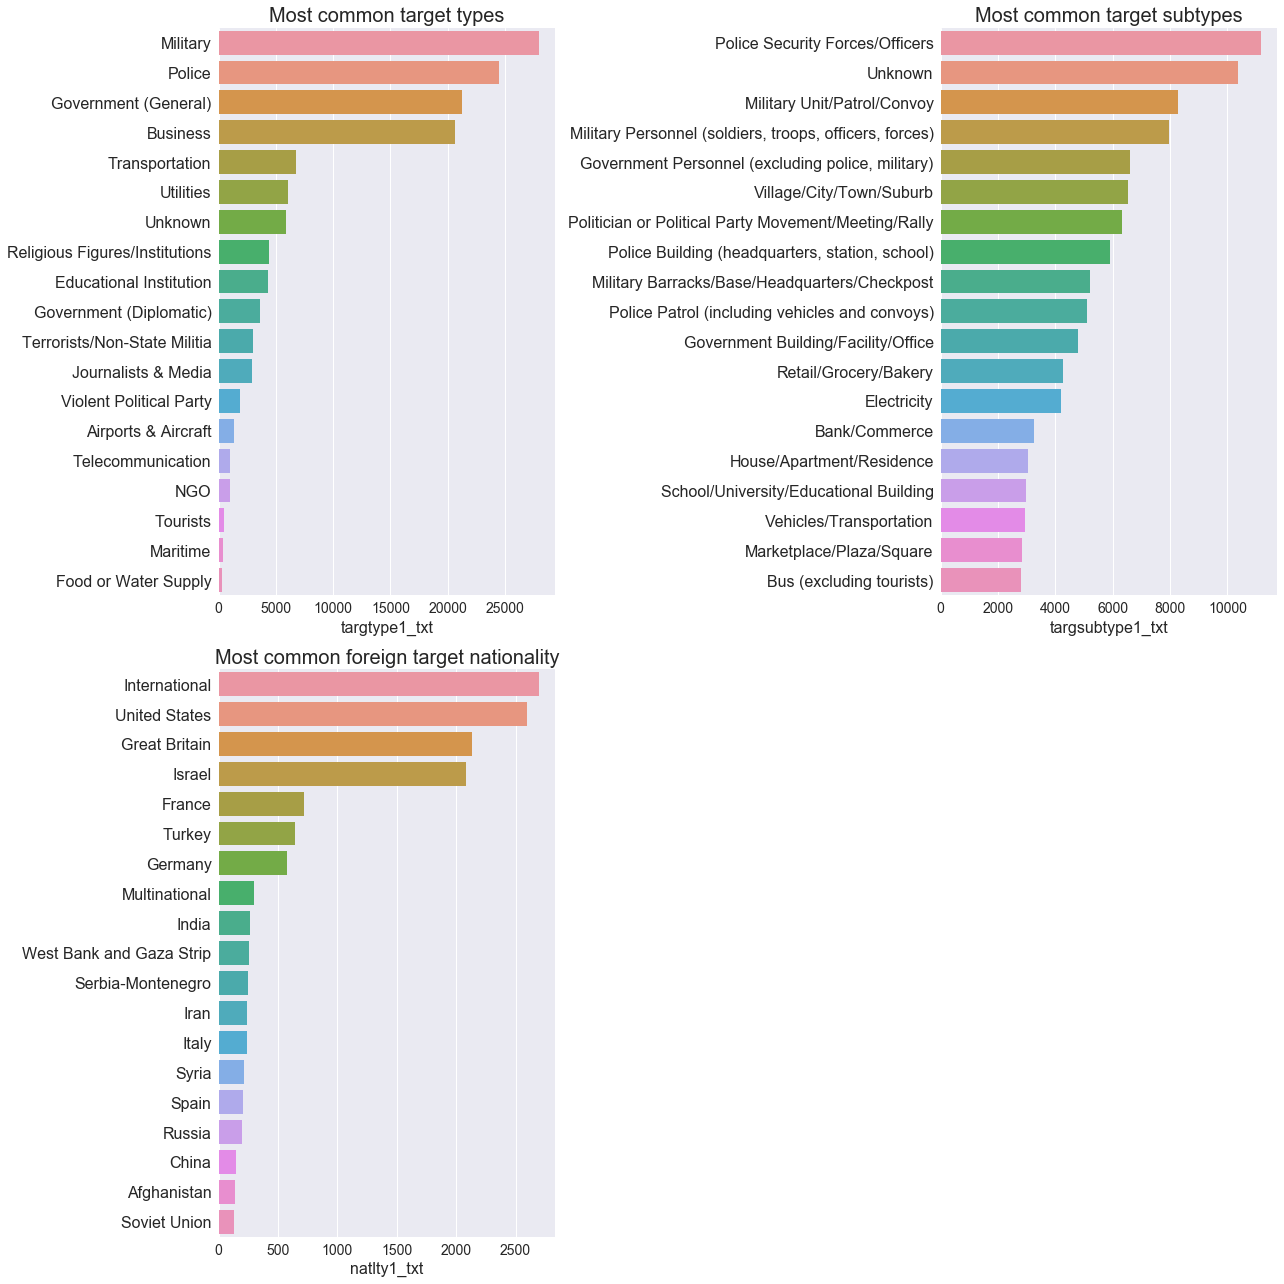

In [111]:
plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(18, 18))

plt.subplot(221)
plt.title('Most common target types')
y = gtd_df.targtype1_txt.value_counts().index[1:20]
x = gtd_df.targtype1_txt.value_counts()[1:20]
plt.xlabel('number of attacks')
sns.barplot(x, y)

plt.subplot(222)
plt.title('Most common target subtypes')
y = hyperspecific_df.targsubtype1_txt.value_counts().index[1:20]
x = hyperspecific_df.targsubtype1_txt.value_counts()[1:20]
plt.xlabel('number of attacks')
sns.barplot(x, y)

plt.subplot(223)
plt.title('Most common foreign target nationality')
y = gtd_df[gtd_df.natlty1_txt!=gtd_df.country_txt].natlty1_txt.value_counts().index[1:20]
x = gtd_df[gtd_df.natlty1_txt!=gtd_df.country_txt].natlty1_txt.value_counts()[1:20]
plt.xlabel('number of attacks')
sns.barplot(x, y)

plt.tight_layout()
plt.show()

### Differential plots (attributed vs unattributed)

First let's take a look at the number of casualties vs. whether the incident is attributed to a perpetrating group, and whether it has been publicly claimed by a perpetrating group.

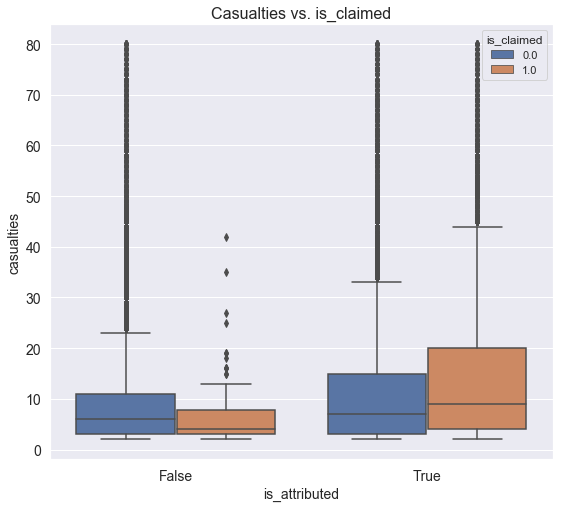

In [30]:
plt.rc('axes', titlesize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

gtd_df['casualties'] = gtd_df.nwound + 3*gtd_df.nkill

plt.figure(figsize=(9,8))
sns.boxplot(gtd_df[gtd_df.casualties.between(2,80)].gname!="Unknown", 
               gtd_df[gtd_df.casualties.between(2,80)].casualties,
              hue=gtd_df[gtd_df.casualties.between(2,80)].claimed)
plt.xlabel('is_attributed')
plt.legend(title='is_claimed')
plt.title("Casualties vs. is_claimed")
plt.show()

gtd_df.drop('casualties', axis=1, inplace=True)

The above plot shows that there is a significant difference in casualty rates between attributed and unattributed attacks: attributed attacks have more casualties.  Given that only 0.1% of all attacks are claimed but unattributed (so the orange boxplot under 'False' is essentially negligable), this means that perpetrator claims correlate not only with whether the attack is attributed, but also higher casualty rates *even among attributed attacks*.

Now let's look at a map version:

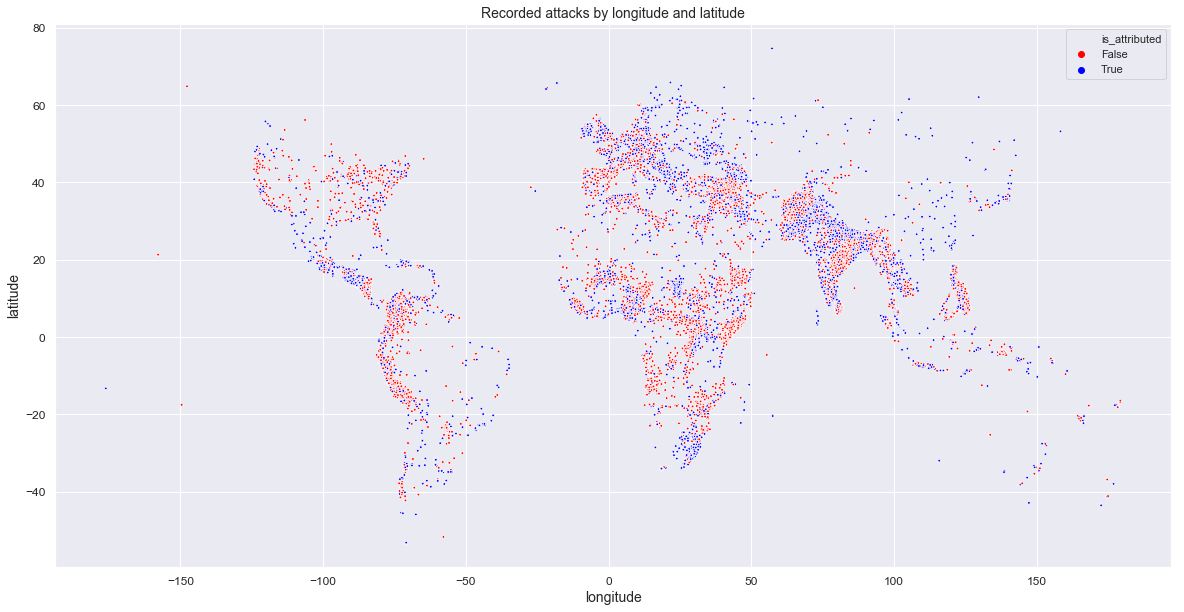

In [12]:
gtd_df['is_attributed'] = gtd_df.gname=='Unknown'

plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=14)

sns.set_palette('bright')
pal = ['red', 'blue']
plt.figure(figsize=(20,10))
sns.scatterplot(x='longitude', 
            y='latitude',
            data=gtd_df,
            s=7, 
            hue='is_attributed',
            palette=pal)
plt.title("Recorded attacks by longitude and latitude")
plt.show()
sns.set()

This map confirms the plots above: the Middle East and South Asia show the highest incident density, while North America and northern Asia are relatively sparse.  We can also see that the unattributed attacks seem to have somewhat different distributions that the attributed ones. 

A small but important note is that there are certain countries in which there are some unattributed attacks but no unattributed attacks whatsoever.  In most cases, this will make attributing these attacks based on the present dataset impossible.  Fortunately, these countries comprise just a tiny fraction of the overall attacks, so they won't effect the accuracy much.  Nevertheless, we would do well to mark these for our final predictor and make sure the attacks aren't predicted with strong confidence / high probability.

In [60]:
unattributed_countries = set(gtd_df[gtd_df.is_attributed].country_txt) - set(gtd_df[~gtd_df.is_attributed].country_txt)
gtd_df.country_txt.value_counts()[unattributed_countries]

Guinea-Bissau          9
Belize                 8
Gambia                 3
Benin                  8
Slovenia               6
Wallis and Futuna      1
Bahamas                5
Grenada                5
South Vietnam          1
North Yemen            6
Antigua and Barbuda    1
Montenegro             5
Mauritius              2
Name: country_txt, dtype: int64

The next plot depicts the largest *differences* in number of attacks of different types, or by different groups, or in different groups, or against different foreign nationalities.  (The nationality of target is almost always the same as the country of the attack; the 'foreign target nationality' subtype shows only cases where the victims are not from the country where the attack took place.)

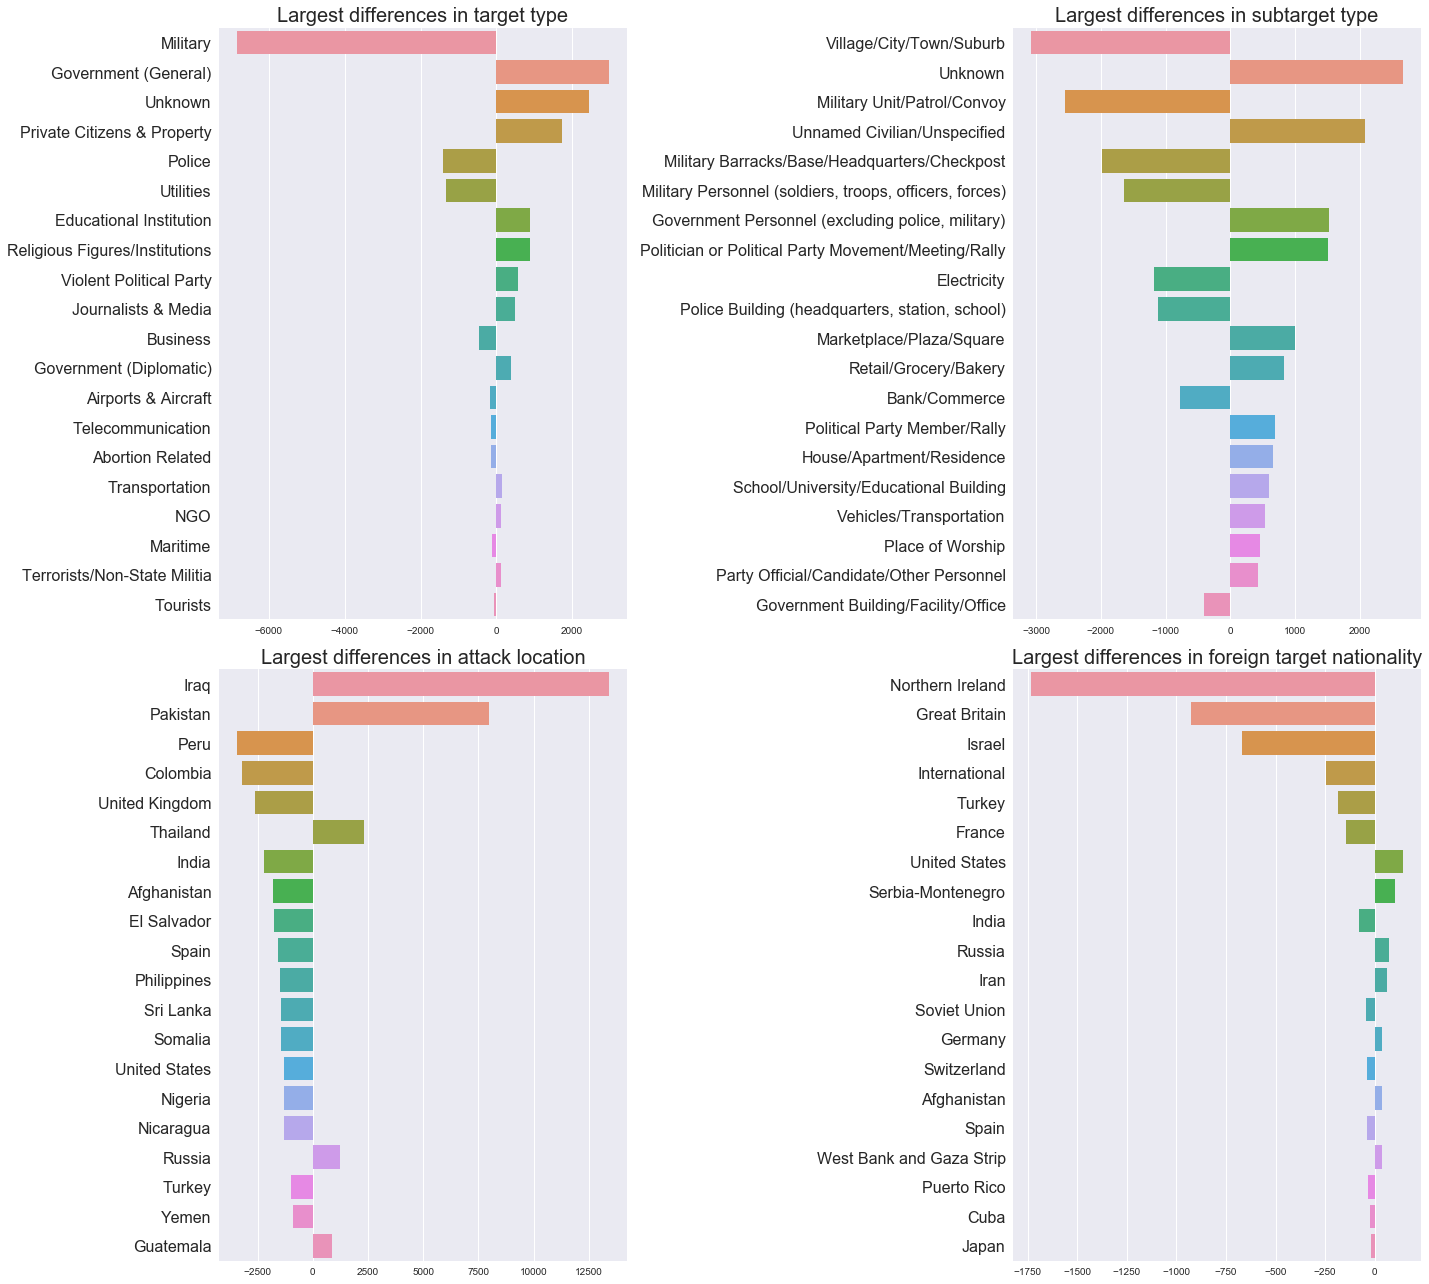

In [31]:
unattr_ratio = sum(gtd_df.gname=='Unknown')/sum(gtd_df.gname!="Unknown")
attributed_df = gtd_df[gtd_df.gname!='Unknown']
unattributed_df = gtd_df[gtd_df.gname=='Unknown']
hyperspecific_attr = hyperspecific_df[hyperspecific_df.gname!='Unknown']
hyperspecific_unattr = hyperspecific_df[hyperspecific_df.gname=='Unknown']

plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(20, 18))

plt.subplot(221)
plt.title('Largest differences in target type')
cat_diff_tups = []
attr_val_counts = attributed_df.sample(frac=unattr_ratio).targtype1_txt.value_counts()
unattr_val_counts = unattributed_df.targtype1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(222)
plt.title('Largest differences in subtarget type')
cat_diff_tups = []
attr_val_counts = hyperspecific_attr.sample(frac=unattr_ratio).targsubtype1_txt.value_counts()
unattr_val_counts = hyperspecific_unattr.targsubtype1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(223)
plt.title('Largest differences in attack location')
cat_diff_tups = []
attr_val_counts = attributed_df.sample(frac=unattr_ratio).country_txt.value_counts()
unattr_val_counts = unattributed_df.country_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(224)
plt.title('Largest differences in foreign target nationality')
cat_diff_tups = []
attr_val_counts = attributed_df[attributed_df.natlty1_txt!=attributed_df.country_txt].sample(frac=unattr_ratio).natlty1_txt.value_counts()
unattr_val_counts = unattributed_df[unattributed_df.natlty1_txt!=unattributed_df.country_txt].natlty1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.tight_layout()
plt.show()

In short, attacks against military or police forces are much less likely to go unattributed.  Attacks against civilians, uncategorized parties, private businesses, or non-military non-police political groups are more likely to go unattributed. This is unsurprising, given that police and military institutions are generally the only organizations equipped with extensive investigatory bodies.  This also explains the difference in foreign target nationalities: these are the countries most likely to have military troops on the ground in foreign nations.

Probably due to extensive military presence as well as high overall rates, Iraq and Pakistan have by far the highest differential in favor of attributed incidents.

Overall, these stats show that to get optimal prediction over the unattributed incidents, we may need to oversample our dataset in favor of attacks NOT against military or police forces, and NOT in Iraq or Pakistan.  However, if we split or segment our data by country at the top of our hierarchical classification model, we would only need to do this for training the model that makes the first split.  We may need to oversample generally for type of target, if we don't segment the data by that feature as well.

<a id='ft_engineering'></a>

# Feature engineering

[back to table of contents](#TOC)


In [421]:
non_domestic_target = [gtd_df.natlty1_txt[i] if gtd_df.natlty1_txt[i] != gtd_df.country_txt[i] else np.nan \
    for i in range(len(gtd_df.natlty1_txt))]

gtd_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=True)
gtd_prepped_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=True)
gtd_filled_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=False)

### Naive Bayes for Hyperspecific categorical columns

In [ ]:
from sklearn.naive_bayes import MultinomialNB

X_train_

for col in hyperspecific_df:
    
    

### Pseudocode for further engineered features:

In [ ]:
# # NAIVE BAYES HYPERSPECIFIC
# split full data WITH hyperspecific columns into train and test sets
# for each hyperspecific_col:
#     - make dataframe of dummies from that column's features
#     - train a multinomialNB on the training portion of that dataframe
#     - get multinomialNB predictions and probabilities for train and test portions of the dataframe
#     - append those predictions and probabilities to the full train and test sets as two new columns
# - To test, fit a classifier on that train set, predict on the test set, and compare results to 
# - the results of that classifier without these two added features

# # BERNOULLI BINARIES:
# - train one BernoulliNB model on a test split of all binary cols in gtd_filled
# - append BernoulliNB predictions and probabilities to the train and test splits of the full dataset
#    - test by fitting a classifier on the training set with the Bernoulli_pred and Bernoulli_prob added,
#    - getting predictions for train and test set, and comparing results to the same train/test split results
#    - without the Bernoulli additions
    
# # NAIVE BAYES GAUSSIAN:
# # (we could also break this down further to Poisson and Gaussian)
# - same as Bernoulli procedure above, but run on all the real-number features instead

# # TEXTUAL FEATURES:
# retool custom function (in parent directory) add_best_words.py to work for multiclass instances
# (this function uses a formula based on Bayes' Theorem to select and add binary word-features for
# the n words that best differentiate target classes)
# add 10-20 best_words per text column

## CITY EXTERNAL DATA:
# - import gdp and gdp/capita by year and country from gdp_data.csv and gdp_per_cap_data.csv
# - find a spreadsheet with majority religion and govt type; import and merge
# - merge into main dataframe

### Feature reduction with GLRM:

Because we have many features, we may want a feature reduction algorithm to allow for more complex clustering algorithms that would be unfeasible on a 70+ feature dataset with 100,000 examples. We also want this featureset to be null-less so we can use sklearn and other non-null-handling libraries.  This algorithm should ideally be able to handle different types of data, including numerical, binary, and categorical.

Probably the best single algorithm that can fulfill all of these needs is Generalized Low-Rank Models. GLRM uses alternating minimization with customizable-by-column cost functions to allow for a PCA- or NNMF-like matrix factorization across various data types. The reduced dataset is null-less and lower-rank than the original. We'll try this here with the number of reduced features set to 30.

#### General-purpose GLRM:

In [168]:
# Load the H2O library and start up the H2O cluster locally on my machine
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,19 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 20 days
H2O cluster name:,garrettfiddler
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [169]:
glrmodel_20 = H2OGeneralizedLowRankEstimator(
                                       k=20,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [164]:
# note: using gtd_prepped_df rather than the full gtd_df here
# because the latter creates a strange nullPointerException in Java 
type_conversions = {
    np.dtype('float64'):'real',
    np.dtype('int64'):'int',
    np.dtype('bool'):'enum',
    np.dtype('object'):'enum',
}

glrm_column_types = {}
coltypes = gtd_filled_df.drop('gname', axis=1).dtypes
for col in gtd_filled_df.drop('gname', axis=1).columns:
    glrm_column_types[col] = type_conversions[coltypes[col]]

In [170]:
gtd_h2 = h2o.H2OFrame(gtd_filled_df.drop('gname', axis=1), column_types=glrm_column_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [171]:
start = time()
glrmodel_20.train(training_frame=gtd_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 21.8 minutes


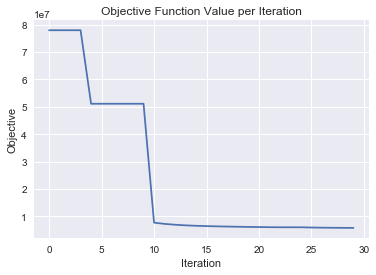

In [172]:
model_score = glrmodel_20.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [173]:
model = glrmodel_20._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_20_df = X.as_data_frame()

print('Projected shape:', glrm_20_df.shape)

Projected shape: (181685, 20)


In [174]:
glrm_20_df.to_csv('glrm_20.csv')

#### GLRM for visualization:

In [159]:
glrmodel_vis = H2OGeneralizedLowRankEstimator(
                                       k=2,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       impute_original=True)

In [160]:
# note: used gtd_prepped_df for this one
start = time()
glrmodel_vis.train(training_frame=gtd_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 3.0 minutes


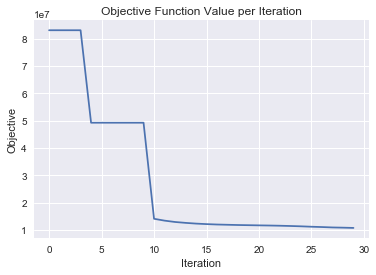

In [161]:
model_score = glrmodel_vis.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [162]:
model = glrmodel_vis._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_vis_df = X.as_data_frame()

print('Projected shape:', glrm_vis_df.shape)

Projected shape: (181685, 2)


In [166]:
glrm_vis_df.to_csv('glrm_vis.csv')

### Clustering

In [ ]:
# models = 
#     k-means
#     Ward agglomerative
#     HDBSCAN # may work best based on *dense* lines in glrm_vis plot

# for each model:
#     for each useful parameter set (if specifying k, try for a couple tiers):
#         use glrm_20 to cluster
#         glrm_vis features to plot
#         use custom function show_silhouettes to plot silhouette scores

<a id='modeling'></a>

# Modeling

[back to table of contents](#TOC)

<a id='initial'></a>
## Initial model trials

Before we start building a hierarchical classification model, it makes sense to try flat classification just as a benchmark.  Given the computational expenses of running it for 3K target classes, we'll first try in on subsets of just the most prolific groups.  This will also give us a run-up to our first model (#1), the frequency-based segmentation classifier.

In [8]:
from time import time
from sklearn.model_selection import train_test_split
import warnings
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize

In [11]:
from time import time
from sklearn.model_selection import train_test_split
import warnings

def quick_test_model(model, X_set, y):
    # NOTE: I'm using accuracy as the sole metric here because it's the same as either micro or macro f1-score
    # for cases where every example belongs to one and only one category
    
    warnings.filterwarnings(action='ignore', category=DeprecationWarning) # arises with current lightGBM + numpy
    
    start = time()
    X_train, X_test, y_train, y_test = train_test_split(X_set, y, test_size=1/3)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_accuracy = round(sum(y_pred_train==y_train)/len(y_train), 3)
    test_accuracy = round(sum(y_pred_test==y_test)/len(y_test), 3)
    
    print("  train accuracy:", train_accuracy)
    print("  test accuracy:", test_accuracy)
    print("elapsed time:", round((time()-start)/60, 1), 'minutes')

In [427]:
next_groups = dummy_df.gname.value_counts()[1:21].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_20 = next_df.gname
X_20_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[1:101].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_100 = next_df.gname
X_100_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[101:201].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_200 = next_df.gname
X_200_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[201:301].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_300 = next_df.gname
X_300_df = next_df.drop('gname', axis=1)

In [95]:
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize

gnbc = GaussianNB()
knc = KNeighborsClassifier(n_neighbors=5, weights='distance')
dtc = DecisionTreeClassifier(class_weight='balanced')
lgbmc = LGBMClassifier(class_weight='balanced')

print("PREDICTING 20 MOST PROLIFIC GROUPS:")
print("\nGaussian Naive Bayes:")
quick_test_model(gnbc, X_20_df, y_20)
print("\nK-neighbors classifier:")
quick_test_model(knc, X_20_df, y_20)
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_20_df, y_20)
print("\nLightGBM:")
quick_test_model(lgbmc, X_20_df, y_20)

print("\nPREDICTING 100 MOST PROLIFIC GROUPS:")
print("\nGaussian Naive Bayes:")
quick_test_model(gnbc, X_100_df, y_100)
print("\nK-neighbors classifier:")
quick_test_model(knc, X_100_df, y_100)
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_100_df, y_100)
print("\nLightGBM:")
quick_test_model(lgbmc, X_100_df, y_100)

print("\nPREDICTING GROUPS 100-200:")
print("\nGaussian Naive Bayes:")
quick_test_model(gnbc, X_200_df, y_200)
print("\nK-neighbors classifier:")
quick_test_model(knc, X_200_df, y_200)
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_200_df, y_200)
print("\nLightGBM:")
quick_test_model(lgbmc, X_200_df, y_200)

print("\nPREDICTING GROUPS 200-300:")
print("\nGaussian Naive Bayes:")
quick_test_model(gnbc, X_300_df, y_300)
print("\nK-neighbors classifier:")
quick_test_model(knc, X_300_df, y_300)
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_300_df, y_300)
print("\nLightGBM:")
quick_test_model(lgbmc, X_300_df, y_300)

PREDICTING 20 MOST PROLIFIC GROUPS:

Gaussian Naive Bayes:
  train accuracy: 0.145
  test accuracy: 0.147
elapsed time: 0.1 minutes

K-neighbors classifier:
  train accuracy: 1.0
  test accuracy: 0.507
elapsed time: 0.2 minutes

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.978
elapsed time: 0.0 minutes

LightGBM:
  train accuracy: 0.998
  test accuracy: 0.985
elapsed time: 0.6 minutes

PREDICTING 100 MOST PROLIFIC GROUPS:

Gaussian Naive Bayes:
  train accuracy: 0.084
  test accuracy: 0.086
elapsed time: 0.8 minutes

K-neighbors classifier:
  train accuracy: 1.0
  test accuracy: 0.429
elapsed time: 0.4 minutes

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.913
elapsed time: 0.1 minutes

LightGBM:
  train accuracy: 0.994
  test accuracy: 0.934
elapsed time: 2.6 minutes

PREDICTING GROUPS 100-200:

Gaussian Naive Bayes:
  train accuracy: 0.145
  test accuracy: 0.143
elapsed time: 0.1 minutes

K-neighbors classifier:
  train accuracy: 1.0
  test 

In [427]:
next_groups = dummy_df.gname.value_counts()[1:21].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_20 = next_df.gname
X_20_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[1:101].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_100 = next_df.gname
X_100_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[101:201].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_200 = next_df.gname
X_200_df = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[201:301].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_300 = next_df.gname
X_300_df = next_df.drop('gname', axis=1)

As anticipated, LightGBM performs the best on all of these data segments.  Somewhat to my surprise, the simplistic decision tree, while being exponentially faster, is also very nearly as accurate.  These results accord nicely with a hierarchical understanding of the data.

As a benchmark, let's try both of these fairly successful models as flat classifiers on a couple version of the full dataset:
- the entire dataset
- all non-singleton attacks (eliminates 48% of the class labels at the cost of discarding 1.7% of the data)
- all non-singleton-or-dual attacks (eliminates 62% of the class labels at the cost of discarding 2.7% of the data)

*Note: as demonstrated in the cells below, DTC is actually more accurate (and faster) without balanced class weights.  LightGBM also produces better results this way. Given this, we'll run both with the default (even) weights henceforth.*

In [21]:
dtc = DecisionTreeClassifier()
quick_test_model(dtc, dummy_df.drop('gname', axis=1), dummy_df.gname)

  train accuracy: 1.0
  test accuracy: 0.8
elapsed time: 0.5 minutes


In [22]:
dtc = DecisionTreeClassifier(class_weight='balanced')
quick_test_model(dtc, dummy_df.drop('gname', axis=1), dummy_df.gname)

  train accuracy: 1.0
  test accuracy: 0.78
elapsed time: 0.9 minutes


In [25]:
next_groups = dummy_df.gname.value_counts()[1:1827].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_non_single = next_df.gname
X_non_single = next_df.drop('gname', axis=1)

next_groups = dummy_df.gname.value_counts()[1:1345].index
next_df = dummy_df[dummy_df.gname.isin(next_groups)]
y_non_dual = next_df.gname
X_non_dual = next_df.drop('gname', axis=1)

next_df = dummy_df[dummy_df.gname!='Unknown']
y_full = next_df.gname
X_full = next_df.drop('gname', axis=1)

In [109]:
lgbmc = LGBMClassifier(boosting_type='goss')

print("PREDICTING OVER FULL DATASET (3536 classes):")
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_full, y_full)
print("\nLightGBM:")
quick_test_model(lgbmc, X_full, y_full)

print("\nPREDICTING OVER NON SINGLETONS (1825 classes):")
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_non_single, y_non_single)
print("\nLightGBM:")
quick_test_model(lgbmc, X_non_single, y_non_single)

print("\nPREDICTING OVER NON SINGLETONS OR DUALS(1343 classes):")
print("\nDecision Tree Classifier:")
quick_test_model(dtc, X_non_dual, y_non_dual)
print("\nLightGBM:")
quick_test_model(lgbmc, X_non_dual, y_non_dual)


PREDICTING OVER FULL DATASET:

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.818
elapsed time: 0.3 minutes

LightGBM:
  train accuracy: 0.005
  test accuracy: 0.005
elapsed time: 26.1 minutes

PREDICTING OVER NON SINGLETONS:

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.821
elapsed time: 0.2 minutes

LightGBM:
  train accuracy: 0.033
  test accuracy: 0.03
elapsed time: 18.4 minutes

PREDICTING OVER NON SINGLETONS OR DUALS:

Decision Tree Classifier:
  train accuracy: 1.0
  test accuracy: 0.798
elapsed time: 0.5 minutes

LightGBM:
  train accuracy: 0.057
  test accuracy: 0.059
elapsed time: 44.3 minutes


This is very interesting: LightGBM outperforms a decision tree when the number of classes is only around a hundred, even when the number of examples per class is small, but its accuracy plummets (and its runtime balloons) when the number of classes expands to over a thousand.  The basic decision tree, on the other hand, is a little less accurate on the limited-number-of-classes case, but its accuracy stays strong even with thousands of classes.  In the case of the entire dataset (3536 classes), it still achieves nearly 78% accuracy and only take 30 seconds to run.  

We may be able to achieve some of the accuracy of the decision tree in lightGBM by building fewer, but much larger, trees.  However, given the success of decision trees, for now our go-to model for many-class prediction will be decision trees.  (For fewer-class prediction we may still want to use lightGBM.)

*Note: for a more detailed look at the lightGBM accuracy delay, see appendix at bottom of notebook*

### A different look at Naive Bayes
Before moving forward, I want to take a quick second look at Naive Bayes. As we saw above, the Gaussian NB didn't perform very well for us.  This makes sense, since our data has mixed distribution types and non-independent features. It should perform better with the GLRM-reduced features because they're more normally distributed and almost entirely independent.

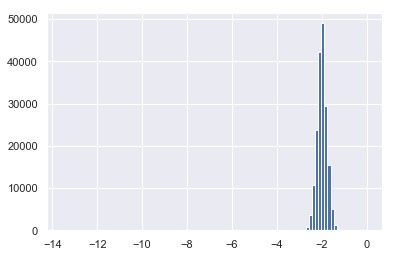

In [47]:
plt.hist(glrm_20_df.Arch1*10, bins=100);

In [58]:
# glrm_20_df = pd.read_csv('glrm_20.csv', index_col=0)
glrm_20_df['gname'] = gtd_df.gname

from sklearn.naive_bayes import GaussianNB

next_groups = glrm_20_df.gname.value_counts()[1:101].index
next_df = glrm_20_df[glrm_20_df.gname.isin(next_groups)]
X_temp_df = pd.get_dummies(next_df.drop('gname', axis=1))
y = next_df.gname
# priors = [y.value_counts()[val]/len(y) for val in y.value_counts().index]

gnbc = GaussianNB()
quick_test_model(gnbc, X_temp_df, y)
glrm_20_df.drop('gname', axis=1, inplace=True)

  train accuracy: 0.249
  test accuracy: 0.252
elapsed time: 0.0 minutes


This is several times better, but still not very good.  What we really want is to use different distribution-assumptions for different features - and ideally, handle the categorical features directly, which is quite possible for Naive Bayes (but sklearn doesn't support categoricals).

Below is a custom categorical-handling Naive Bayes package I wrote for this project.  It only handles categorical features right now, since those are the ones sklearn can't handle.  However, it could be combined with existing packages to make the ideal mixed-type Naive Bayes classifier.  (This package also handles nulls without issue.)

In [9]:
from catNB import CatNB
from sklearn.model_selection import train_test_split
from time import time

next_groups = gtd_df.gname.value_counts()[1:21].index
next_df = gtd_df.select_dtypes('object')[gtd_df.gname.isin(next_groups)]
y_temp = next_df.gname
X_temp_df = next_df.drop('gname', axis=1)

cnbc = CatNB()

quick_test_model(cnbc, X_temp_df, y_temp)

  train accuracy: 0.967
  test accuracy: 0.933
elapsed time: 1.1 minutes


In [10]:
from catNB import CatNB

next_groups = gtd_df.gname.value_counts()[1:101].index
next_df = gtd_df.select_dtypes('object')[gtd_df.gname.isin(next_groups)]
y_temp = next_df.gname
X_temp_df = next_df.drop('gname', axis=1)

cnbc = CatNB()
quick_test_model(cnbc, X_temp_df, y_temp)

  train accuracy: 0.388
  test accuracy: 0.3
elapsed time: 7.7 minutes


This classifier works quite well for the top 20 groups - almost as well as LightGBM running on ALL the features (keep in mind that catNB is running exclusively on the categorical features here).  However, when the dataset is expanded to the top 100 groups, the accuracy plummets, whereas LightGBM holds its accuracy pretty well until it gets into the 100+ range, and decision trees hold their accuracy across the entire dataset.  So categoricalNB may be helpful as a boosting feature, but probably not as a predictive model itself (unless perhaps combined with a GaussianNB model for the numerical data).

It's worth noting, however, that this custom package significantly outperformed the GaussianNB (even on the more normally-distributed GLRM data) while using only half the available data (it didn't use any of the numeric features).  This proves its usefulness as a tool, even if it's not the best solution for this many-classed problem.

## Randomized decision tree

Fully deterministic decision trees are greedy algorithms - which means that their path is not necessarily optimal.  Let's try adding some randomness to the mix to see if another path might prove better.

In [34]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(dummy_df.gname)
# X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop('gname', axis=1), y, test_size=0.3)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop('gname', axis=1), y, test_size=0.3)
scores = []
topscore = 0
model = None
for i in range(5):
    random_params = {
        'splitter': 'random',
        'max_features': 0.95,
        'random_state': i,    
    }
    dtc = DecisionTreeClassifier(**random_params)
    dtc.fit(X_train, y_train)
    score = sum(dtc.predict(X_test)==y_test)/len(y_test)
    scores.append(score)
    if score > topscore:
        topscore = score
        model = dtc
    
print(round(topscore, 3))

0.786


In [36]:
scores = []
topscore = 0
model = None
for i in range(5):
    random_params = {
        'splitter': 'random',
        'max_features': 0.75,
        'random_state': i,    
    }
    dtc = DecisionTreeClassifier(**random_params)
    dtc.fit(X_train, y_train)
    score = sum(dtc.predict(X_test)==y_test)/len(y_test)
    scores.append(score)
    if score > topscore:
        topscore = score
        model = dtc
    
print(round(topscore, 3))

0.765


In [37]:
scores = []
topscore = 0
model = None
for i in range(5):
    random_params = {
        'splitter': 'random',
        'max_features': 0.5,
        'random_state': i,    
    }
    dtc = DecisionTreeClassifier(**random_params)
    dtc.fit(X_train, y_train)
    score = sum(dtc.predict(X_test)==y_test)/len(y_test)
    scores.append(score)
    if score > topscore:
        topscore = score
        model = dtc
    
print(round(topscore, 3))

0.76


In [ ]:
scores = []
topscore = 0
model = None
for i in range(5):
    random_params = {
        'max_features': 0.85,
        'random_state': i,    
    }
    dtc = DecisionTreeClassifier(**random_params)
    dtc.fit(X_train, y_train)
    score = sum(dtc.predict(X_test)==y_test)/len(y_test)
    scores.append(score)
    if score > topscore:
        topscore = score
        model = dtc
    
print(round(topscore, 3))

None of these scored significantly higher than the deterministic decision tree.  For now, we'll stick with the deterministic version.

Now, out of curiosity, let's try reducing the specificity (and potential overfitting) of our decision tree and see what results that produces:

In [ ]:
dtc = DecisionTreeClassifier(min_samples_leaf=4)
quick_test_model(dtc, dummy_df, y)

dtc = DecisionTreeClassifier(min_samples_leaf=8)
quick_test_model(dtc, dummy_df, y)

dtc = DecisionTreeClassifier(min_samples_leaf=12)
quick_test_model(dtc, dummy_df, y)

We could certainly do a more detailed investigation here, plotting learning curves for min_samples_leaf, min_impurity_decrease, and min_samples_split.  However, the early results here just aren't promising enough to warrant the time and space.  We'll flag this as a possible tweak and move on for now.

<a id='tiers'></a>

## Decision tree with probability tiers

In [39]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(dummy_df.gname)

In [67]:
for i in [4,6,8,10,13,16,20]:
    print('\n***Results for min_samples_split={}***'.format(i))
    dtc = DecisionTreeClassifier(min_samples_split=i)
    quick_test_model(dtc, dummy_df.drop('gname', axis=1), y)


***Results for min_samples_split=4***
  train accuracy: 0.96
  test accuracy: 0.797
elapsed time: 0.5 minutes

***Results for min_samples_split=6***
  train accuracy: 0.939
  test accuracy: 0.795
elapsed time: 0.5 minutes

***Results for min_samples_split=8***
  train accuracy: 0.923
  test accuracy: 0.791
elapsed time: 0.5 minutes

***Results for min_samples_split=10***
  train accuracy: 0.91
  test accuracy: 0.795
elapsed time: 0.5 minutes

***Results for min_samples_split=13***
  train accuracy: 0.896
  test accuracy: 0.794
elapsed time: 0.5 minutes

***Results for min_samples_split=16***
  train accuracy: 0.885
  test accuracy: 0.792
elapsed time: 0.4 minutes

***Results for min_samples_split=20***
  train accuracy: 0.872
  test accuracy: 0.792
elapsed time: 0.4 minutes


In [292]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, brier_score_loss

def top_predictions(X, y, model, n_predictions, test_size=1/3, verbose=True):

    # NOTE on the encoder: we have to keep y_test un-encoded because it contains classes not in y_train
    # (if we encode entire dataset, predict_proba output is indecipherable; the columns are 
    # 0-->len(unique(y_train)), on the assumption that y_test is restricted to vals in y_train)
    
    if n_predictions > len(np.unique(y)):
        return ValueError("Number of top predictions requested cannot exceed number of classes")
    
    start = time()
    if verbose:
        print("Training model...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Parse tiered probabilities
    probs = pd.DataFrame(model.predict_proba(X_test))
    max_column_indices = np.argsort(probs.values, axis=1)[:, -n_predictions:]
    sorted_probs = np.sort(probs.values, axis=1)[:, -n_predictions:]
    col_columns = ["prediction_" + str(i) for i in range(n_predictions, 0, -1)]
    columns_df = pd.DataFrame(encoder.inverse_transform(max_column_indices), columns=col_columns)
    val_columns = ["probability_" + str(i) for i in range(n_predictions, 0, -1)]
    probs_df = pd.DataFrame(sorted_probs, columns=val_columns)
    predictions_df = pd.concat([columns_df, probs_df], axis=1)
    
    # sort columns to prediction_1, prediction_2... probability_1, probability_2...
    prediction_indices = [i for i in range(n_predictions-1, -1, -1)]
    probability_indices = [i + n_predictions for i in prediction_indices]
    predictions_df = predictions_df.iloc[:, prediction_indices + probability_indices]
    
    # replace zero-probability predictions with None
    is_absolute = pd.Series(predictions_df.probability_1 >= 0.99)
    prediction_cols = predictions_df.columns[:n_predictions]
    for col in prediction_cols[1:]:
        predictions_df.loc[is_absolute, col] = None
    
    if verbose:
        # calculate and print model accuracy & runtime
        train_accuracy = round(sum(y_pred_train==y_train)/len(y_train), 3)
        test_accuracy = round(sum(encoder.inverse_transform(y_pred_test)==y_test)/len(y_test), 3)
        print("  train accuracy:", train_accuracy)
        print("  test accuracy:", test_accuracy)
        print("elapsed time:", round((time()-start)/60, 1), 'minutes')
        
        # calculate stats for the cumulative n_predictions output
        pct_absolute = round(100*sum(predictions_df.probability_1 >= 0.99)/predictions_df.shape[0], 1)
        
        prediction_cols = predictions_df.columns[:n_predictions]
        probability_cols = predictions_df.columns[n_predictions:]
        
        # average probability of prediction for non_absolute predictions
        av_non_abs_probabilities = []
        for i in range(n_predictions):
            av_non_abs_probabilities.append(
                round( predictions_df[ predictions_df.probability_1 < 0.99 ][probability_cols[i]].mean(), 2) 
            )
        
        # absolute vs. non-absolute prediction accuracies
        y_test = y_test.reset_index(drop=True)
        is_absol = pd.Series(predictions_df.probability_1 >= 0.99)
        absol_accuracy = round(sum(predictions_df.prediction_1[is_absol]==y_test[is_absol])/sum(is_absol), 3)
        isnt_absol = pd.Series(predictions_df.probability_1 < 0.99)
        unabsol_accuracy = round(sum(predictions_df.prediction_1[isnt_absol]==y_test[isnt_absol])/sum(isnt_absol), 3)
        
        # cumulative accuracy of top n_predictions (y_true is one of n_predictions) for non-absolute predictions
        total_accuracy_non_absol = 0
        for i in range(n_predictions):
            total_accuracy_non_absol += \
                sum(predictions_df[prediction_cols[i]][isnt_absol]==y_test[isnt_absol])/sum(isnt_absol)
        total_accuracy_non_absol = round(total_accuracy_non_absol, 3)
        
        # cumulative accuracy of top n_predictions (y_true is one of n_predictions) for all predictions
        total_accuracy = 0
        for i in range(n_predictions):
            total_accuracy += \
                sum(predictions_df[prediction_cols[i]]==y_test)/len(y_test)
        total_accuracy = round(total_accuracy, 3)
        
        # log loss
        y_true = (predictions_df.prediction_1==y_test)
        y_pred = predictions_df.probability_1
        primary_log_loss = round(log_loss(y_true, y_pred), 3)
        primary_brier_score = round(brier_score_loss(y_true, y_pred), 3)
        
        # brier score
        y_true = sum(
            [ (predictions_df[prediction_cols[i]] == y_test).astype(int) \
                for i in range(n_predictions) ] 
        )
        y_pred = (predictions_df.probability_1 + predictions_df.probability_2 + predictions_df.probability_3)
        total_log_loss = round(log_loss(y_true, y_pred), 3)
        total_brier_score = round(brier_score_loss(y_true, y_pred), 3)
        
        # print results
        print("\nPercent of predictions that are absolute (probability > 0.99):   {}%".format(pct_absolute))
        print("\nAccuracies")
        print("  Accuracy of absolute predictions:                             ", absol_accuracy)
        print("  Accuracy of primary non-absolute predictions:                 ", unabsol_accuracy)
        print("  Cumulative accuracy of all top predictions when non-absolute: ", total_accuracy_non_absol)
        print("  Total cumulative accuracy of all top predictions in all cases:", total_accuracy)
        
        print("\nWhen prediction is not absolute, average probability value returned for: ")
        for i in range(1, n_predictions+1):
            print("  prediction {}: {}".format(i, av_non_abs_probabilities[i-1]))
        
        print("\nLog-loss and brier scores:")
        print("  Primary prediction log loss:           ", primary_log_loss)
        print("  Primary prediction brier score:        ", primary_brier_score)
        print("  Cumulative top predictions log loss:   ", total_log_loss)
        print("  Cumulative top predictions brier score:", total_brier_score)
    
    return predictions_df


X = dummy_df.drop('gname', axis=1)
y = dummy_df.gname
dtc = DecisionTreeClassifier(min_samples_split=30)
preds = top_predictions(X, y, dtc, 3)
preds.head()

Training model...
  train accuracy: 0.85
  test accuracy: 0.78
elapsed time: 0.5 minutes

Percent of predictions that are absolute (probability > 0.99):   62.7%

Accuracies
  Accuracy of absolute predictions:                              0.948
  Accuracy of primary non-absolute predictions:                  0.498
  Cumulative accuracy of all top predictions when non-absolute:  0.726
  Total cumulative accuracy of all top predictions in all cases: 0.865

When prediction is not absolute, average probability value returned for: 
  prediction 1: 0.59
  prediction 2: 0.19
  prediction 3: 0.08

Log-loss and brier scores:
  Primary prediction log loss:            1.361
  Primary prediction brier score:         0.11
  Cumulative top predictions log loss:    2.059
  Cumulative top predictions brier score: 0.101


,prediction_1,prediction_2,prediction_3,probability_1,probability_2,probability_3
0,Catalan Liberation Front (FAC),Iberian Liberation Movement (MIL),First of October Antifascist Resistance Group ...,0.625000,0.166667,0.083333
1,Baloch Liberation Army (BLA),United Baloch Army (UBA),Baloch Republican Army (BRA),0.588235,0.235294,0.117647
2,Revolutionary Armed Forces of Colombia (FARC),None,None,1.000000,0.000000,0.000000
3,Islamic State of Iraq and the Levant (ISIL),None,None,1.000000,0.000000,0.000000
4,Revolutionary Armed Forces of Colombia (FARC),None,None,1.000000,0.000000,0.000000


This report shows the most useful output we could get from our single model, viz.:
- for 63% of cases, the model returns a strong prediction that's 95% accurate
- for the remaining 37% of cases, the model returns the top three predictions, where:
  - the first prediction is accurate in 51% of cases
  - one of these top three predictions is accurate in 73% of cases
  
This is far more useful than a single-prediction model, because we can know which predictions we can be confident in, which predictions we can't, and what the best secondary candidates are in unconfident cases.

<a id='hierarchical'></a>

# Hierarchical classification ensembles

[back to table of contents](#TOC)


<a id='frequency'></a>

## 1. Frequency-based segmented classification

We know that lightGBM can predict very accurately over the top 20 groups (0.987) or top 100 groups (0.938), but is much less accurate across the whole dataset.  Meanwhile, a regular decision tree can predict fairly accurately across the entire dataset, but can't reach the peak that lightGBM can.

If we can predict accurately enough which attacks are by prolific vs. non-prolific groups (e.g. which are carried out by top-100 groups), we may be able to achieve higher overall accuracy by first segmenting the data based on whether the attack was by a prolific group, and then predicting prolific-group-attacks with lightGBM and non-prolific-group-attacks with a decision tree.

In [2]:
print("Top 20 groups account for {} percent of attributed attacks".format(
    round( sum(gtd_df.gname.value_counts()[1:21])/sum(gtd_df.gname.value_counts()[1:])*100, 1) )
     )
print("Top 100 groups account for {} percent of attributed attacks".format(
    round( sum(gtd_df.gname.value_counts()[1:101])/sum(gtd_df.gname.value_counts()[1:])*100, 1) )
     )   
print("Top 200 groups account for {} percent of attributed attacks".format(
    round( sum(gtd_df.gname.value_counts()[1:201])/sum(gtd_df.gname.value_counts()[1:])*100, 1) )
     )

Top 20 groups account for 51.7 percent of attributed attacks
Top 100 groups account for 76.4 percent of attributed attacks
Top 200 groups account for 84.8 percent of attributed attacks


In [4]:
def is_in_prolif_range(start, end, df=dummy_df):
    top_n = df.gname.value_counts().index[start:end]
    return df.gname.isin(top_n)
    
# top_20 = gtd_prepped_df.gname.value_counts().index[1:21]
# is_top_20 = gtd_prepped_df.gname.isin(top_20)
# next_30 = gtd_df.gname.value_counts().index[21:51]
# is_next_30 = gtd_df.gname.isin(next_30)

print("Predictive accuracy for whether attack is by one of the top n most prolific groups:")
    
print("\nTop 20:")
quick_test_model(LGBMClassifier(class_weight='balanced'), dummy_df.drop('gname', axis=1), is_in_prolif_range(1,21))

print("\nTop 50:")
quick_test_model(LGBMClassifier(class_weight='balanced'), dummy_df.drop('gname', axis=1), is_in_prolif_range(1,51))

print("\nTop 100:")
quick_test_model(LGBMClassifier(class_weight='balanced'), dummy_df.drop('gname', axis=1), is_in_prolif_range(1,101))

print("\nTop 200:")
quick_test_model(LGBMClassifier(class_weight='balanced'), dummy_df.drop('gname', axis=1), is_in_prolif_range(1,201))

print("\nTop 200 (but not top 50):")
quick_test_model(LGBMClassifier(class_weight='balanced'), dummy_df.drop('gname', axis=1), is_in_prolif_range(51,201))

Predictive accuracy for whether attack is by one of the top n most prolific groups:

Top 20:
  train accuracy: 0.947
  test accuracy: 0.943
elapsed time: 0.2 minutes

Top 50:
  train accuracy: 0.923
  test accuracy: 0.921
elapsed time: 0.2 minutes

Top 100:
  train accuracy: 0.914
  test accuracy: 0.904
elapsed time: 0.2 minutes

Top 200:
  train accuracy: 0.893
  test accuracy: 0.886
elapsed time: 0.2 minutes

Top 200 (but not top 50):
  train accuracy: 0.866
  test accuracy: 0.856
elapsed time: 0.2 minutes


Some things we learned from these tests, in combination with previous accuracy tests:
- we can predict the top 20 groups at 0.962 segmenting accuracy * 0.987 lightGBM classification accuracy = 0.949 accuracy on the 52% of the data.
- we can predict the top 100 groups at 94% segmenting * 93% classification = 87.5% accuracy on 76% of the data

Let's give these a quick spin.

In [13]:
def test_freq_seg(start, stop, df=dummy_df, target='gname', drop_singletons=False):
    '''
    df: all categoricals numerically coded EXCEPT target, which is still included
    '''
    warnings.filterwarnings(action='ignore', category=DeprecationWarning) # arises with current lightGBM + numpy

    start_time = time()
    # split data
    X_train, X_test, y_train, y_test = train_test_split(df, df[target], test_size=1/3)
    
    # segment data
    top_groups = X_train[target].value_counts().index[start:stop]
    train_segment_labels = X_train[target].isin(top_groups)
    test_segment_labels = X_test[target].isin(top_groups)
    X_train = X_train.drop(target, axis=1)
    X_test = X_test.drop(target, axis=1)
    
    lgbmc = LGBMClassifier(class_weight='balanced')
    lgbmc.fit(X_train, train_segment_labels)
    train_segment_predictions = lgbmc.predict(X_train)
    test_segment_predictions = lgbmc.predict(X_test)
    
    seg_train_acc = sum(train_segment_predictions == train_segment_labels) / len(train_segment_labels)
    seg_test_acc = sum(test_segment_predictions == test_segment_labels) / len(test_segment_labels)
    print("Segmentation train accuracy:", round(seg_train_acc, 3))
    print("Segmentation test accuracy:", round(seg_test_acc, 3))
    
    X_train_top = X_train[train_segment_predictions]
    y_train_top_actual = y_train[train_segment_predictions]
    y_train_top = [val if val in top_groups else top_groups[0] for val in y_train[train_segment_predictions]]
    # so that for fitting, LGBMC chooses only from the top X labels
    X_train_rest = X_train[~train_segment_predictions]
    y_train_rest = y_train[~train_segment_predictions]
    X_test_top = X_test[test_segment_predictions]
    y_test_top = y_test[test_segment_predictions]
    X_test_rest = X_test[~test_segment_predictions]
    y_test_rest = y_test[~test_segment_predictions]
    
    # predict top groups with lightGBM:
    lgbmc.fit(X_train_top, y_train_top)
    top_train_preds = lgbmc.predict(X_train_top)
    top_test_preds = lgbmc.predict(X_test_top)
    top_train_acc = sum(top_train_preds==y_train_top_actual) / len(y_train_top_actual)
    top_test_acc = sum(top_test_preds==y_test_top) / len(y_test_top)
    print("\nLightGBM TRAIN accuracy on top groups:", round(top_train_acc, 3))
    print("LightGBM TEST accuracy on top groups:", round(top_test_acc, 3))
    
    # predict lesser groups with decision tree:
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train_rest, y_train_rest)
    rest_train_preds = dtc.predict(X_train_rest)
    rest_test_preds = dtc.predict(X_test_rest)
    rest_train_acc = sum(rest_train_preds==y_train_rest) / len(y_train_rest)
    rest_test_acc = sum(rest_test_preds==y_test_rest) / len(y_test_rest)
    print("\nDecision Tree TRAIN accuracy on rest of groups:", round(rest_train_acc, 3))
    print("Decision Tree TEST accuracy on rest of groups:", round(rest_test_acc, 3))

    # output total accuracy:
    train_acc = (sum(top_train_preds==y_train_top_actual) + sum(rest_train_preds == y_train_rest)) / \
                    (len(y_train_top) + len(y_train_rest))
    test_acc = (sum(top_test_preds==y_test_top) + sum(rest_test_preds == y_test_rest)) / \
                    (len(y_test_top) + len(y_test_rest))
    print("\nTotal train accuracy:", round(train_acc, 3))
    print("Total test accuracy:", round(test_acc, 3))
    print("\nelapsed time:", round((time()-start_time)/60, 1), 'minutes')

Top 20:

In [14]:
test_freq_seg(0, 20, dummy_df)

Segmentation train accuracy: 0.95
Segmentation test accuracy: 0.947

LightGBM TRAIN accuracy on top groups: 0.933
LightGBM TEST accuracy on top groups: 0.92

Decision Tree TRAIN accuracy on rest of groups: 1.0
Decision Tree TEST accuracy on rest of groups: 0.675

Total train accuracy: 0.964
Total test accuracy: 0.806

elapsed time: 0.9 minutes


Top 100:

In [15]:
test_freq_seg(0, 100, dummy_df)

Segmentation train accuracy: 0.891
Segmentation test accuracy: 0.884

LightGBM TRAIN accuracy on top groups: 0.962
LightGBM TEST accuracy on top groups: 0.904

Decision Tree TRAIN accuracy on rest of groups: 1.0
Decision Tree TEST accuracy on rest of groups: 0.581

Total train accuracy: 0.973
Total test accuracy: 0.807

elapsed time: 4.1 minutes


Top 200:

In [16]:
test_freq_seg(0, 200, dummy_df)

Segmentation train accuracy: 0.853
Segmentation test accuracy: 0.845

LightGBM TRAIN accuracy on top groups: 0.178
LightGBM TEST accuracy on top groups: 0.165

Decision Tree TRAIN accuracy on rest of groups: 1.0
Decision Tree TEST accuracy on rest of groups: 0.552

Total train accuracy: 0.398
Total test accuracy: 0.271

elapsed time: 3.7 minutes


It looks like we're topping out at around 81% here.  A few hyperparameter sweeps (both on the model itself, and on the number of top groups we're selecting here) could probably get us to around 85%.  We may be able to eke a few more percentage points from changing the number of top criteria, or doing several tiers.  For now, we'll flag this as our best coposite model so far and move on to other types of segmentation.

<a id='feature-based'></a>

## 2. Feature-based segmented classification
[back to table of contents](#TOC)


This may essentially amount to the same things as a decision tree, since a decision tree already segments data based on feature values.  However, these decision tree algorithms are blindly greedy algorithms, so they may not be globally optimal.  While it's not certain or even likely to do so, manually setting certain initial segmentation criteria that we know to be important may be able to force a better model.

My intuition is that our first split in a natural-feature segmentation should be by region.  But let's take a look at our decision tree feature importances to find out:

  train accuracy: 1.0
  test accuracy: 0.795
elapsed time: 0.6 minutes


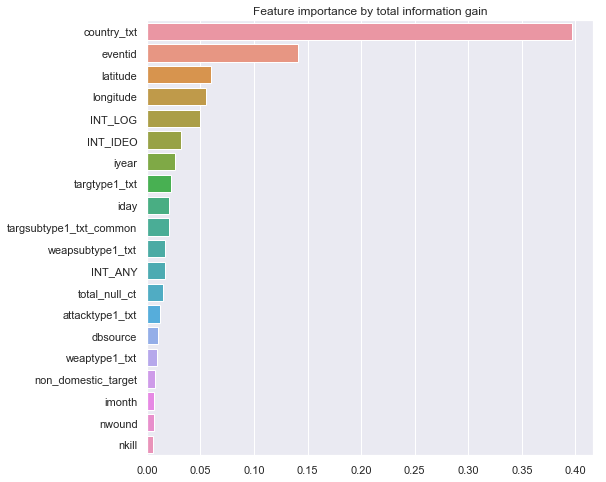

In [23]:
# fit tree and print accuracy to confirm it's working correctly
dtc = DecisionTreeClassifier()
quick_test_model(dtc, dummy_df.drop('gname', axis=1), dummy_df.gname)

# label and sort feature importances
fi_tups = sorted(zip(dummy_df.drop('gname', axis=1).columns, dtc.feature_importances_), key=lambda x: -x[1])

# compile importances for all dummies of each categorical feature
for str_col in gtd_filled_df.select_dtypes('object').columns:
    matching_tups = []
    summed_imp = (str_col, 0)
    for tup in fi_tups:
        if str_col in tup[0]:
            summed_imp = (summed_imp[0], summed_imp[1] + tup[1])
            matching_tups.append(tup)
    fi_tups.append(summed_imp)
    for tup in matching_tups:
        fi_tups.remove(tup)
fi_tups = sorted(fi_tups, key=lambda x: -x[1])

# plot
plt.figure(figsize=(8,8))
x_imp = [tup[0] for tup in fi_tups[:20]]
y_labels = [tup[1] for tup in fi_tups[:20]]
sns.barplot(y_labels, x_imp)
plt.title("Feature importance by total information gain")
plt.show()

Interesting: while the decision tree uses country heavily, region doesn't make the top 20 cut.  But region is superfluous if country is being used; it serves as a high-level categorization of which countries are relevant. To confirm this, we can look at the feature importances of a decision tree fitted on the data without country included:

  train accuracy: 1.0
  test accuracy: 0.794
elapsed time: 0.4 minutes


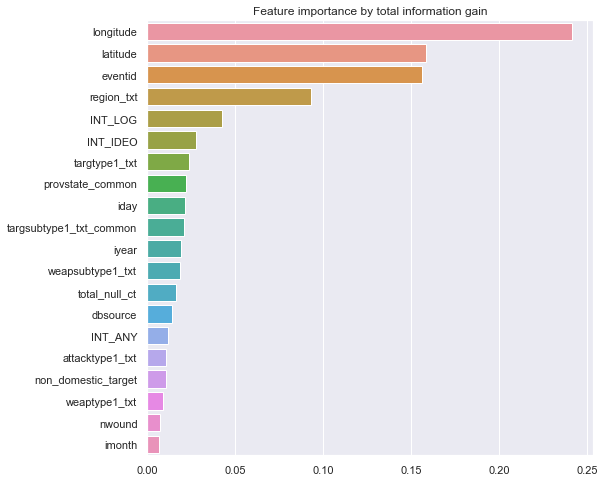

In [10]:
# WITHOUT COUNTRY_TXT
# fit tree and print accuracy to confirm it's working correctly
dtc = DecisionTreeClassifier()
country_cols = [col for col in dummy_df.columns if 'country_txt' in col]
quick_test_model(dtc, dummy_df.drop(country_cols + ['gname'], axis=1), dummy_df.gname)

# label and sort feature importances
fi_tups = sorted(
    zip(dummy_df.drop(country_cols + ['gname'], axis=1).columns, dtc.feature_importances_), key=lambda x: -x[1])

# compile importances for all dummies of each categorical feature
for str_col in gtd_filled_df.select_dtypes('object').columns:
    matching_tups = []
    summed_imp = (str_col, 0)
    for tup in fi_tups:
        if str_col in tup[0]:
            summed_imp = (summed_imp[0], summed_imp[1] + tup[1])
            matching_tups.append(tup)
    fi_tups.append(summed_imp)
    for tup in matching_tups:
        fi_tups.remove(tup)
fi_tups = sorted(fi_tups, key=lambda x: -x[1])

# plot
plt.figure(figsize=(8,8))
x_imp = [tup[0] for tup in fi_tups[:20]]
y_labels = [tup[1] for tup in fi_tups[:20]]
sns.barplot(y_labels, x_imp)
plt.title("Feature importance by total information gain")
plt.show()

Now region is one of the most significant factors.  Longitude and latitude are also much more heavily relied on.  Basically, the tree can reconstruct the information in the 'country' feature from region, longitude, and latitude.  The INT_LOG feature for whether an attack was logistically international is very high in both models.

All of this suggests that we should classify based on region, INT_LOG, country, and possibly a synthetic latitude/longitude cluster label.  Let's give this a spin.

In [29]:
segments = [gtd_filled_df[gtd_filled_df.gname!='Unknown']]
start = time()

split_features = ['region_txt', 'country_txt', 'INT_LOG']
for feature in split_features:
    new_segments = []
    for segment in segments:
        new_segments.extend([segment[segment[feature]==val] for val in segment[feature].unique()])
    segments = new_segments

# remove empty segments or segments too small to train-test split
segments = [segment for segment in segments if segment.shape[0] >= 4]

segment_train_accuracies = []
segment_test_accuracies = []
rows_processed = 0

for segment in segments:
    X_train, X_test, y_train, y_test = train_test_split(
        pd.get_dummies(segment.drop('gname', axis=1)), segment.gname, test_size=0.25)
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train)
    train_pred = dtc.predict(X_train)
    test_pred = dtc.predict(X_test)
    segment_train_accuracies.append( sum(train_pred==y_train) / len(y_train) )
    segment_test_accuracies.append( sum(test_pred==y_test) / len(y_test) )
    rows_processed += segment.shape[0]
    print('{}% of rows processed'.format(round(100*rows_processed/dummy_df.shape[0])), end='\r')
    
segment_proportions = [segment.shape[0] / dummy_df.shape[0] for segment in segments]
total_train_accuracy = sum(
    [tup[0] * tup[1] for tup in zip(segment_train_accuracies, segment_proportions)] )
total_test_accuracy = sum(
    [tup[0] * tup[1] for tup in zip(segment_test_accuracies, segment_proportions)] )

print('total train accuracy:', round(total_train_accuracy, 3))
print('total test accuracy:', round(total_test_accuracy, 3))
print("elapsed time:", round((time()-start)/60, 1), 'minutes')

total train accuracy: 0.998
total test accuracy: 0.806
elapsed time: 0.3 minutes


Like frequency-based segmentation, this gets us a significant but small accuracy gain (this one is a little smaller, 0.809-->0.806).  Ultimately, this is unsurprising, given that we're basically just telling the decision tree where to split first.

We may have better results using a different type of model (perhaps lightGBM or Random Forest) on some or all segments.

<a id='cluster-based'></a>

## 3. Cluster-based hierarchical classification
[back to table of contents](#TOC)


### Compile profiles

In [227]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer

def compile_profiles(dummy_df, scaler=StandardScaler(), importance_quotient=2, include_singletons=True):
    '''
    Note: it's important to scale BEFORE performing groupby because the groupby runs multiple agg functions
    on some columns that should have a fixed relation to each other (e.g., median, max, var)
    Also: importance_quotient upscales important columns after scaling to increase their clustering influence
    '''
    start = time()
    
    if not include_singletons:
        dummy_df = dummy_df[dummy_df.gname in dummy_df.gname.value_counts()[1:1826]]
    
    # dummy out the quasi-binary columns that also have a lot of -9 flags, so that they're basically nan-as-cat
    dummy_temp_df = dummy_df.drop(['gname', 'eventid', 'iday'], axis=1)
    for col in ['INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'vicinity', 'property']:
        dummy_temp_df[col] = dummy_temp_df[col].astype(str)
    dummy_temp_df = pd.get_dummies(dummy_temp_df)
    dummy_temp_df['gname'] = dummy_df.gname

    # set agg functions
    agg_funcs = {}
    for col in dummy_temp_df.select_dtypes(['uint8', 'bool']).columns:
        agg_funcs[col] = ['mean']
    for col in dummy_temp_df.select_dtypes(['int64', 'float64']).columns:
        agg_funcs[col] = ['median', 'max', 'var']
    dummy_temp_df['attacks'] = dummy_temp_df.gname
    agg_funcs['attacks'] = 'count'

    # perform groupy and flatten multi_index
    group_profiles_df = dummy_temp_df.groupby('gname', as_index=False).agg(agg_funcs)
    group_profiles_df.columns = ['_'.join(col) for col in group_profiles_df.columns]
    # a strange pandas bug sometimes adds a _ to the end of gname, so:
    group_profiles_df.columns = [col if not col.endswith('_') else col[:-1] for col in group_profiles_df.columns]

    # median-impute variance for singletons (otherwise is NaN)
    if include_singletons:
        for variance_col in [col for col in group_profiles_df.columns if col.endswith('_var')]:
            group_profiles_df[variance_col] = group_profiles_df[variance_col].fillna(
                group_profiles_df[variance_col].median())
    
    # apply scaler
    columnlist = list(group_profiles_df.columns)
    columnlist.remove('gname')
    group_profiles_df = pd.concat(
        [group_profiles_df.gname,
         pd.DataFrame(scaler.fit_transform(group_profiles_df.drop('gname', axis=1)), columns=columnlist)], 
        axis=1)

    # give extra weight to dummy cols to account for the fact that they only have
    # one column (mean) whereas real-val columns have three (median, max, var)
    for dummy_col in dummy_temp_df.select_dtypes(['uint8', 'bool']).columns:
        group_profiles_df[dummy_col + '_mean'] = group_profiles_df[dummy_col + '_mean'] * 3
    # then give a little extra weight to some features we know are particularly important:
    for orig_col in ['country_txt', 'INT_LOG', 'latitude', 'longitude', 'attacks_count']:
        for col in [col for col in group_profiles_df.columns if orig_col in col]:
            group_profiles_df[col] = 2 * group_profiles_df[col]
    # and a larger boost for attacks_count, since its natural variance is enormous
    group_profiles_df['attacks_count'] = group_profiles_df.attacks_count * 2
    
    del dummy_temp_df
    print('elapsed time:', round((time()-start)/60, 1), "minutes")
    return group_profiles_df

# try normalizing ALL cols, and try normalizing ONLY non-dummy cols

In [228]:
gprofs_standard_df = compile_profiles(dummy_df, StandardScaler())
gprofs_robust_df = compile_profiles(dummy_df, RobustScaler())
gprofs_normed_df = compile_profiles(dummy_df, Normalizer())

elapsed time: 0.0 minutes
elapsed time: 0.0 minutes
elapsed time: 0.0 minutes


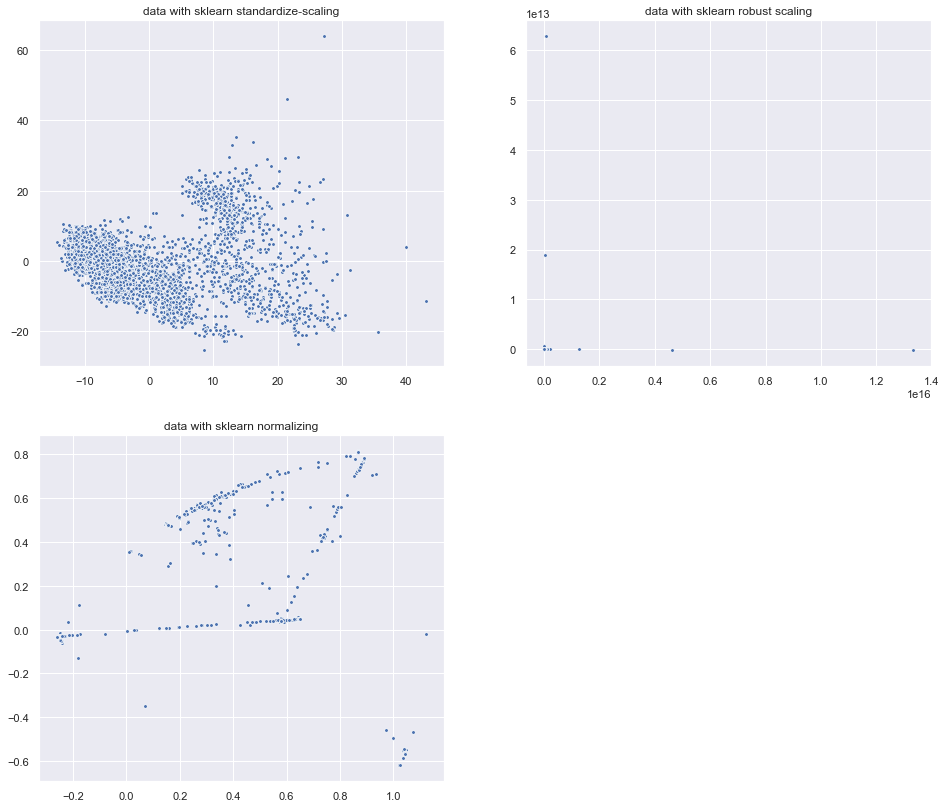

In [66]:
from sklearn.decomposition import PCA
vis_standard_df = PCA(n_components=2).fit_transform(gprofs_standard_df.drop('gname', axis=1))
vis_robust_df = PCA(n_components=2).fit_transform(gprofs_robust_df.drop('gname', axis=1))
vis_normed_df = PCA(n_components=2).fit_transform(gprofs_normed_df.drop('gname', axis=1))


plt.figure(figsize=(16,14))
plt.subplot(221)
sns.scatterplot(vis_standard_df[:,0], vis_standard_df[:,1], s=14)
plt.title('data with sklearn standardize-scaling')
plt.subplot(222)
sns.scatterplot(vis_robust_df[:,0], vis_robust_df[:,1], s=14)
plt.title('data with sklearn robust scaling')
plt.subplot(223)
sns.scatterplot(vis_normed_df[:,0], vis_normed_df[:,1], s=14)
plt.title('data with sklearn normalizing')
plt.show()

It looks like the standard scaling (z-score standardization) is the best method here.  The robust scaling, which uses median and IQR rather than mean and variance to scale, emphasizes the outliers too much to be useful for visualization (though it still may be useful for clustering).  The normalization results are interesting but look to be of dubious value to clustering.

One other idea: try a random forest or GBT with only 10-20 trees, but all trees full-size (like my DT) and close-to-1 bagging ratios.

In [3]:
gprofs_standard_df.head()

,gname,coordinates_are_approx_mean,has_second_attacktype_mean,is_related_mean,country_txt_Afghanistan_mean,country_txt_Albania_mean,country_txt_Algeria_mean,country_txt_Andorra_mean,country_txt_Angola_mean,country_txt_Antigua and Barbuda_mean,...,ransompaidus_median,ransompaidus_max,ransompaidus_var,total_null_ct_median,total_null_ct_max,total_null_ct_var,n_unreleased_median,n_unreleased_max,n_unreleased_var,attacks_count
0,1 May,1.240788,-0.707220,1.709477,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,0.540050,0.728531,-0.387881,-0.102607,-0.136135,-0.058195,-6.058415e+205
1,14 K Triad,-0.681998,-0.707220,9.344090,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,-0.861709,-1.006402,-0.325627,-0.102607,-0.136135,-0.058195,-8.081159e+205
2,14 March Coalition,-0.681998,21.019188,-1.066746,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,-1.842940,-2.163023,-0.262495,-0.102607,-0.136135,-0.058195,-9.092532e+205
3,14th of December Command,-0.681998,-0.707220,-1.066746,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,0.820402,0.728531,-0.536983,-0.102607,-0.136135,-0.058195,-8.418284e+205
4,15th of September Liberation Legion,-0.681998,-0.707220,-1.066746,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,0.399874,0.150220,-0.262495,-0.102607,-0.136135,-0.058195,-9.092532e+205


### Obtain hierarchical labels with hierarchical clustering

*Note: I tried the section below with linkage='complete' as well; it produced a slightly more promising cluster-accuracy-prediction curve, but equally unimpressive target-prediction results.*

In [330]:
from sklearn.cluster import AgglomerativeClustering
X = gprofs_standard_df.set_index('gname')
cluster_labels = pd.DataFrame(gprofs_standard_df.gname)
for i in range(1,11):
    cluster_labels['cluster_label_' + str(i)] = \
        AgglomerativeClustering(n_clusters=(2**i), linkage='ward').fit_predict(X)

In [145]:
cluster_labels.head()

,gname,cluster_label_1,cluster_label_2,cluster_label_3,cluster_label_4,cluster_label_5,cluster_label_6,cluster_label_7,cluster_label_8,cluster_label_9,cluster_label_10
0,1 May,1,0,0,4,21,43,43,43,11,297
1,14 K Triad,1,0,0,4,8,44,89,179,359,719
2,14 March Coalition,0,1,2,3,3,37,37,0,84,693
3,14th of December Command,1,0,1,7,25,51,51,51,94,85
4,15th of September Liberation Legion,1,0,1,6,2,36,36,231,231,61


In [331]:
cluster_labels_full = pd.merge(
    left=pd.DataFrame(dummy_df.gname), 
    right=cluster_labels, 
    on='gname', 
    how='left')
cluster_labels_full.head()

,gname,cluster_label_1,cluster_label_2,cluster_label_3,cluster_label_4,cluster_label_5,cluster_label_6,cluster_label_7,cluster_label_8,cluster_label_9,cluster_label_10
0,MANO-D,1,0,1,6,2,13,93,187,376,93
1,23rd of September Communist League,1,0,0,5,11,52,52,214,82,401
2,Black Nationalists,1,0,0,5,11,62,61,13,90,66
3,Tupamaros (Uruguay),1,0,1,7,7,26,101,203,407,407
4,New Year's Gang,1,0,0,5,11,62,61,13,49,662


### Test hierarchical prediction

<b>There are two ways to use these labels for hierarchical prediction:</b>
- <b>single-tier:</b> predict classes for one tier, and then predict the target class within each class of that tier
- <b>successive tiers:</b> predict classes for each successive tier until the classes are small enough for easy target prediction

Of course it's possible to do a model that's halfway between as well (e.g. successive tiers for four levels, then predict target class), but these are the essential distinctions. For both of these methods, it will be helpful to first have an idea of the flat prediction accuracy of predicting each tier's classes.

cluster_label_1:
  train accuracy: 1.0
  test accuracy: 0.981
elapsed time: 0.1 minutes


cluster_label_2:
  train accuracy: 1.0
  test accuracy: 0.979
elapsed time: 0.1 minutes


cluster_label_3:
  train accuracy: 1.0
  test accuracy: 0.971
elapsed time: 0.1 minutes


cluster_label_4:
  train accuracy: 1.0
  test accuracy: 0.966
elapsed time: 0.1 minutes


cluster_label_5:
  train accuracy: 1.0
  test accuracy: 0.962
elapsed time: 0.1 minutes


cluster_label_6:
  train accuracy: 1.0
  test accuracy: 0.955
elapsed time: 0.2 minutes


cluster_label_7:
  train accuracy: 1.0
  test accuracy: 0.957
elapsed time: 0.2 minutes


cluster_label_8:
  train accuracy: 1.0
  test accuracy: 0.928
elapsed time: 0.2 minutes


cluster_label_9:
  train accuracy: 1.0
  test accuracy: 0.882
elapsed time: 0.2 minutes


cluster_label_10:
  train accuracy: 1.0
  test accuracy: 0.862
elapsed time: 0.2 minutes




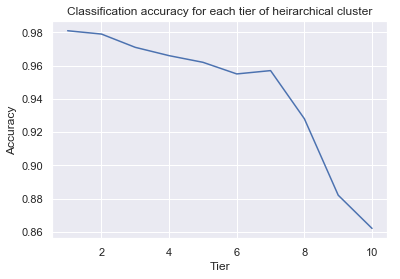

In [300]:
dtc = DecisionTreeClassifier()
flat_accuracies = []

for i in range(1,11):
    start = time()
    y = cluster_labels_full['cluster_label_' + str(i)]
    X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop(['eventid', 'gname'], axis=1), y, test_size=1/3)
    dtc.fit(X_train, y_train)
    y_pred_train = dtc.predict(X_train)
    y_pred_test = dtc.predict(X_test)
    train_accuracy = round(sum(y_pred_train==y_train)/len(y_train), 3)
    test_accuracy = round(sum(y_pred_test==y_test)/len(y_test), 3)
    flat_accuracies.append(test_accuracy)
    
    print('cluster_label_' + str(i) + ':')
    print("  train accuracy:", train_accuracy)
    print("  test accuracy:", test_accuracy)
    print("elapsed time:", round((time()-start)/60, 1), 'minutes')
    print('\n')

plt.plot(range(1,11), flat_accuracies)
plt.title("Classification accuracy for each tier of heirarchical cluster")
plt.xlabel("Tier")
plt.ylabel("Accuracy")
plt.show()

This shows us that it's easy to predict quite accurately (>95%) for tiers 1-7.  From tier 8 onward, the accuracy drops significantly.  Based on these results, our single-tier model should probably predict the 7th tier only, and we may want to perform a successive-tier version that cuts off at tier 7 or 8.

### Single-tier hierarchical prediction:

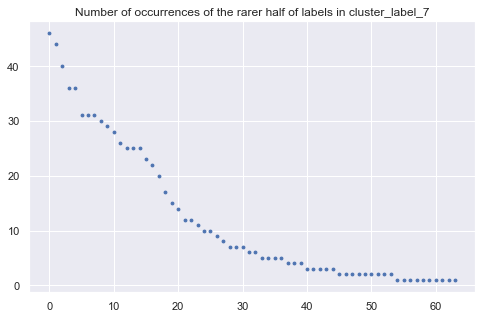

In [224]:
plt.figure(figsize=(8,5))
plt.scatter(range(64), cluster_labels_full.cluster_label_7.value_counts()[-64:], s=8)
plt.title('Number of occurrences of the rarer half of labels in cluster_label_7')
plt.show()

In [301]:
dtc = DecisionTreeClassifier()

# compile y vals
y = pd.concat([cluster_labels_full['cluster_label_7'].reset_index(drop=True), dummy_df['gname'].reset_index(drop=True)], axis=1)
# replace rare cluster labels (less than 40 instances) with -1
rare_labels = y['cluster_label_7'].value_counts()[y['cluster_label_7'].value_counts()<150].index
y.loc[y['cluster_label_7'].isin(rare_labels),'cluster_label_7'] = -1

start = time()
# test accuracy
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop(['eventid', 'gname'], axis=1), y, test_size=1/3)
y_train_1 = y_train['cluster_label_7']
y_train_2 = y_train['gname']
y_test_1 = y_test['cluster_label_7']
y_test_2 = y_test['gname']

dtc.fit(X_train, y_train_1)
y_pred_train_1 = dtc.predict(X_train)
y_pred_test_1 = dtc.predict(X_test)
test_label_accuracy = round(sum(y_pred_test_1==y_test_1)/len(y_test_1), 3)
print("  Labeling accuracy:", test_label_accuracy)

train_accuracies = []
train_sizes = []
test_accuracies = []
test_sizes = []
accurate_labels = []
full_train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
full_test_df = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_test_1), y_test_2.reset_index(drop=True)], axis=1)
full_test_df.columns = list(full_test_df.columns[:-2]) + ['cluster_label_7', 'gname']
i = 1
labels = np.unique(y_pred_train_1)
for label in labels:
    print('training model', i, 'of', len(labels), end='\r')
    # data prep
    X_train_temp = full_train_df[full_train_df.cluster_label_7 == label].drop(['cluster_label_7','gname'], axis=1)
    X_test_temp = full_test_df[full_test_df.cluster_label_7 == label].drop(['cluster_label_7','gname'], axis=1)
    y_train_temp = full_train_df[full_train_df.cluster_label_7 == label].gname
    y_test_temp = full_test_df[full_test_df.cluster_label_7 == label].gname
    train_sizes.append(len(y_train_temp))
    test_sizes.append(len(y_test_temp))
    # fit model and append scores
    dtc.fit(X_train_temp, y_train_temp)
    y_pred_train_temp = dtc.predict(X_train_temp)
    y_pred_test_temp = dtc.predict(X_test_temp)
    train_accuracy = round(sum(y_pred_train_temp==y_train_temp)/len(y_train_temp), 4)
    test_accuracy = round(sum(y_pred_test_temp==y_test_temp)/len(y_test_temp), 4)
    if test_accuracy > 0.85:
        accurate_labels.append(label)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    i += 1

train_weights = [size/sum(train_sizes) for size in train_sizes]
test_weights = [size/sum(test_sizes) for size in test_sizes]
train_accuracy = round(sum([train_accuracies[i]*train_weights[i] for i in range(len(train_accuracies))]), 2)
test_accuracy = round(sum([test_accuracies[i]*test_weights[i] for i in range(len(test_accuracies))]), 2)
print('\n')
print("  train accuracy:", train_accuracy)
print("  test accuracy:", test_accuracy)
print("elapsed time:", round((time()-start)/60, 1), 'minutes')
print("Accurate labels (>0.85):", accurate_labels)

  Labeling accuracy: 0.958
training model 47 of 47

  train accuracy: 1.0
  test accuracy: 0.79
elapsed time: 0.3 minutes
Accurate labels (>0.85): [1, 9, 13, 17, 18, 20, 22, 26, 34, 42, 51, 63, 68, 76, 79]


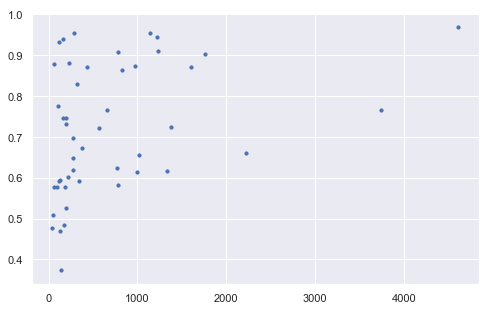

In [302]:
plt.figure(figsize=(8,5))
plt.scatter(test_sizes, test_accuracies, s=10)
plt.show()

We can also try keeping only the accurate cluster labels separate, and grouping all the cluster labels with less-than-average accuracy together in order to leverage the larger amount of data:

In [303]:
# compile y vals
y = pd.concat([cluster_labels_full['cluster_label_7'].reset_index(drop=True), dummy_df['gname'].reset_index(drop=True)], axis=1)
# replace rare cluster labels (less than 40 instances) with -1
rare_labels = y['cluster_label_7'].value_counts()[y['cluster_label_7'].value_counts()<150].index
y.loc[y['cluster_label_7'].isin(rare_labels),'cluster_label_7'] = -1
y.loc[~y['cluster_label_7'].isin(accurate_labels),'cluster_label_7'] = -1

start = time()
# test accuracy
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop(['eventid', 'gname'], axis=1), y, test_size=1/3)
y_train_1 = y_train['cluster_label_7']
y_train_2 = y_train['gname']
y_test_1 = y_test['cluster_label_7']
y_test_2 = y_test['gname']

dtc.fit(X_train, y_train_1)
y_pred_train_1 = dtc.predict(X_train)
y_pred_test_1 = dtc.predict(X_test)
test_label_accuracy = round(sum(y_pred_test_1==y_test_1)/len(y_test_1), 3)
print("  Labeling accuracy:", test_label_accuracy)

train_accuracies = []
train_sizes = []
test_accuracies = []
test_sizes = []
full_train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
full_test_df = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_test_1), y_test_2.reset_index(drop=True)], axis=1)
full_test_df.columns = list(full_test_df.columns[:-2]) + ['cluster_label_7', 'gname']
i = 1
labels = np.unique(y_pred_train_1)
for label in labels:
    print('training model', i, 'of', len(labels), end='\r')
    # data prep
    X_train_temp = full_train_df[full_train_df.cluster_label_7 == label].drop(['cluster_label_7','gname'], axis=1)
    X_test_temp = full_test_df[full_test_df.cluster_label_7 == label].drop(['cluster_label_7','gname'], axis=1)
    y_train_temp = full_train_df[full_train_df.cluster_label_7 == label].gname
    y_test_temp = full_test_df[full_test_df.cluster_label_7 == label].gname
    train_sizes.append(len(y_train_temp))
    test_sizes.append(len(y_test_temp))
    # fit model and append scores
    dtc.fit(X_train_temp, y_train_temp)
    y_pred_train_temp = dtc.predict(X_train_temp)
    y_pred_test_temp = dtc.predict(X_test_temp)
    train_accuracy = round(sum(y_pred_train_temp==y_train_temp)/len(y_train_temp), 4)
    test_accuracy = round(sum(y_pred_test_temp==y_test_temp)/len(y_test_temp), 4)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    i += 1

train_weights = [size/sum(train_sizes) for size in train_sizes]
test_weights = [size/sum(test_sizes) for size in test_sizes]
train_accuracy = round(sum([train_accuracies[i]*train_weights[i] for i in range(len(train_accuracies))]), 2)
test_accuracy = round(sum([test_accuracies[i]*test_weights[i] for i in range(len(test_accuracies))]), 2)
print('\n')
print("  train accuracy:", train_accuracy)
print("  test accuracy:", test_accuracy)
print("elapsed time:", round((time()-start)/60, 1), 'minutes')

  Labeling accuracy: 0.99
training model 16 of 16

  train accuracy: 1.0
  test accuracy: 0.8
elapsed time: 0.5 minutes


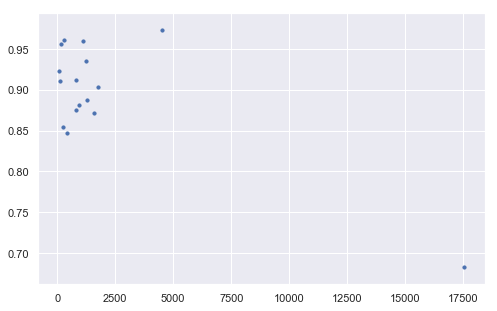

In [304]:
plt.figure(figsize=(8,5))
plt.scatter(test_sizes, test_accuracies, s=10)
plt.show()

Both of these methods scored right around 0.8 – essentially the same accuracy as our flat classifier, or maybe a touch higher, and slightly lower than our frequency-segmented model.  As always, we could try fine-tuning this in various ways(e.g., using different predictive models on the groups that our decision tree doesn't label very accurately here), but for now, let's move on.

### Successive-tier hierarchical prediction:

In [313]:
def hier_classify(X_train, X_test, y_train, y_test, max_tier=10):
    start = time()    
    progress = [0, len(X_test)]
    accudict={}
    for i in range(1, max_tier+1):
        accudict[i] = []
    
    def classify(X_train, X_test, y_train, y_test, accudict, progress, tier=1):
        '''accudict should be an empty dict; it will store labeling accuracies for each tier'''

        dtc = DecisionTreeClassifier()

        # base case:
        if tier > max_tier or X_train.shape[0] < 50:
            y_temp_train = y_train['gname']
            y_temp_test = y_test['gname']
            dtc.fit(X_train, y_temp_train)
            y_train_pred = dtc.predict(X_train)
            y_test_pred = dtc.predict(X_test)
            progress[0] += len(y_test)
            print('Predicted', round(100* progress[0] / progress[1]), '% of test rows', end='\r') 
            return pd.concat([X_test.eventid, pd.Series(y_test_pred)], axis=1)

        # recursive case:       
        else:
            # predict next level of tiers beneath the present tier label
            y_train_temp = y_train['cluster_label_'+str(tier)]
            y_test_temp = y_test['cluster_label_'+str(tier)]
            dtc.fit(X_train, y_train_temp)
            y_train_pred = dtc.predict(X_train)
            y_test_pred = dtc.predict(X_test)

            # log tier-label accuracy in accudict
            accudict[tier].append( sum(y_test_pred==y_test_temp) / len(y_test_temp) )

            # get target predictions from lower levels
            test_preds = None
            for label in np.unique(y_test_pred):
                train_rows = (y_train['cluster_label_'+str(tier)]==label).reset_index(drop=True)
                test_rows = (y_test['cluster_label_'+str(tier)]==label).reset_index(drop=True)
                if sum(test_rows) < 1:
                    continue
                test_preds_temp = classify(
                    X_train.reset_index(drop=True)[train_rows],
                    X_test.reset_index(drop=True)[test_rows],
                    y_train.reset_index(drop=True)[train_rows],
                    y_test.reset_index(drop=True)[test_rows],
                    accudict,
                    progress,
                    tier+1 )
                if test_preds is None:
                    test_preds = pd.DataFrame(test_preds_temp)
                else:
                    test_preds = pd.concat([test_preds, pd.DataFrame(test_preds_temp)], axis=0)

            return test_preds

    test_preds = classify(
        X_train,
        X_test,
        y_train,
        y_test,
        accudict,
        progress,
        1 )
    
    # sort test preds to original order
    test_preds = pd.merge(pd.DataFrame(X_test.eventid), test_preds, on='eventid', how='left')[0]
    
    # print results
    print('\nUnweighted average labeling accuracy for each tier:')
    for i in range(1,max_tier+1):
        print("  Tier {}: {}".format(
            i, 
            round(np.mean(accudict[i]), 3)) )  
    accuracy = round(sum(test_preds==y_test.gname.reset_index(drop=True))/len(test_preds), 3)
    print('\nTest accuracy:', accuracy)
    print("elapsed time:", round((time()-start)/60, 1), 'minutes')
    return test_preds

In [314]:
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop('gname', axis=1), cluster_labels_full, test_size=1/3)
test_preds = hier_classify(
    X_train,
    X_test,
    y_train,
    y_test,
    10
)

Predicted 100 % of test rows
Unweighted average labeling accuracy for each tier:
  Tier 1: 0.98
  Tier 2: 0.998
  Tier 3: 0.992
  Tier 4: 0.994
  Tier 5: 0.996
  Tier 6: 0.995
  Tier 7: 0.995
  Tier 8: 0.968
  Tier 9: 0.948
  Tier 10: 0.949

Test accuracy: 0.645
elapsed time: 1.1 minutes


In [306]:
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop('gname', axis=1), cluster_labels_full, test_size=1/3)
test_preds = hier_classify(
    X_train,
    X_test,
    y_train,
    y_test,
    10
)

Predicted 99 % of test rows
Unweighted average labeling accuracy for each tier:
  Tier 1: 0.981
  Tier 2: 0.999
  Tier 3: 0.994
  Tier 4: 0.996
  Tier 5: 0.996
  Tier 6: 0.995
  Tier 7: 0.975
  Tier 8: 0.958
  Tier 9: 0.929
  Tier 10: 0.903

Test accuracy: 0.665
elapsed time: 1.1 minutes


In [307]:
# with only 7 tiers:
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop('gname', axis=1), cluster_labels_full, test_size=1/3)
test_preds = hier_classify(
    X_train,
    X_test,
    y_train,
    y_test,
    7
)

Predicted 100 % of test rows
Unweighted average labeling accuracy for each tier:
  Tier 1: 0.981
  Tier 2: 0.998
  Tier 3: 0.994
  Tier 4: 0.996
  Tier 5: 0.996
  Tier 6: 0.997
  Tier 7: 0.971

Test accuracy: 0.502
elapsed time: 0.9 minutes


In [308]:
# with only 5 tiers:
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop('gname', axis=1), cluster_labels_full, test_size=1/3)
test_preds = hier_classify(
    X_train,
    X_test,
    y_train,
    y_test,
    5
)

Predicted 100 % of test rows
Unweighted average labeling accuracy for each tier:
  Tier 1: 0.979
  Tier 2: 0.998
  Tier 3: 0.994
  Tier 4: 0.996
  Tier 5: 0.997

Test accuracy: 0.248
elapsed time: 0.6 minutes


While the tier labeling *looks* significantly more accurate using this recursive hierarchical prediction, given the dismal predictive results, this is probably due to these accuracies being unweighted.  My guess is that this could be at least reasonably effective, but it would take extensive manual adjustments, including:
- adjust clusters at each level (merging some smaller ones) based on size and entropy
- split some clusters further than others
- use different models for different batches

For the time being, since this is a lot of work for questionable returns, it's probably better to stick with our flat DTC model.

<a id='boosting'></a>


## Hierarchical cluster predictions as additions (boosts) to the main decision tree

In [341]:
labels_append_df = cluster_labels_full.iloc[:,1:8].copy()
for label in labels_append_df.columns:
    rare_labels = labels_append_df[label].value_counts()[labels_append_df[label].value_counts()<160].index
    labels_append_df.loc[labels_append_df[label].isin(rare_labels),label] = -1
    labels_append_df[label] = labels_append_df[label].astype(str)
    print(label, labels_append_df[label].nunique())

cluster_label_1 2
cluster_label_2 4
cluster_label_3 7
cluster_label_4 14
cluster_label_5 23
cluster_label_6 41
cluster_label_7 47


#### 1. With perfectly accurate gname hierarchical labels:

In [332]:
X_train, X_test, y_train, y_test = train_test_split(dummy_df.drop(['eventid', 'gname'], axis=1), cluster_labels_full, test_size=1/3)
y_train_1 = y_train['cluster_label_7']
y_train_2 = y_train['gname']
y_test_1 = y_test['cluster_label_7']
y_test_2 = y_test['gname']

dtc.fit(X_train, y_train_1)
y_pred_train_1 = dtc.predict(X_train)
y_pred_test_1 = dtc.predict(X_test)
test_label_accuracy = round(sum(y_pred_test_1==y_test_1)/len(y_test_1), 3)
print("  Labeling accuracy:", test_label_accuracy)

  Labeling accuracy: 0.955


In [342]:
X = pd.concat(
    [
        dummy_df.drop(['gname'], axis=1).reset_index(drop=True), 
        pd.get_dummies(labels_append_df).reset_index(drop=True) ],
    axis=1)

dtc = DecisionTreeClassifier()
quick_test_model(dtc, X, dummy_df.gname)

  train accuracy: 1.0
  test accuracy: 0.816
elapsed time: 0.5 minutes


With perfect hierarchical labeling, our accuracy gain here is a bit more than the gain we've seen from other methods here 0.816 > 0.809).  With predicted hierarchical labeling, this will probably fall to roughly the same gain we've seen.

<a id='final-model'></a>

# Final optimal model: hyperspecific DTC with ranked predictions

[back to table of contents](#TOC)

In [334]:
# It's fast enough to handle it, and it could make it significantly more accurate.

# from initial cleaning:
hyperspecific_cols = [
    'natlty1_txt',      # 210 distinct values, but almost entirely identical to 'country_txt'
    'provstate',        # useful, but 2855 distinct values
    #'city',             # useful, but 36672 distinct values
    'targsubtype1_txt', # 112 distinct values, with dwindling tail of value counts
]

gtd_raw_df = pd.read_csv('globalterrorismdb_0718dist.csv', low_memory=False)
gtd_df, gtd_prepped_df, gtd_filled_df = load_and_clean(gtd_raw_df)
del gtd_raw_df, gtd_prepped_df

def top_n_cats(series, n=10, keep_nulls=False):
    top_n = series.value_counts().index[:n]
    if keep_nulls:
        top_n = list(top_n) + [np.nan]
    return pd.Series([val if val in top_n else 'other' for val in series])  

gtd_hyper = gtd_filled_df.copy()
for col in hyperspecific_cols:
    gtd_hyper[col+'_common'] = gtd_df[col] 
gtd_hyper['city_common'] = top_n_cats(gtd_df.city, n=6000)
gtd_hyper.fillna('Unknown', inplace=True)


gtd_hyper_gname = gtd_hyper[gtd_hyper.gname!='Unknown'].gname
gtd_hyperdummy = pd.get_dummies(gtd_hyper[gtd_hyper.gname!='Unknown'].drop('gname', axis=1))

quick_test_model(DecisionTreeClassifier(), gtd_hyperdummy, gtd_hyper_gname)

# del gtd_df, gtd_hyper, gtd_hyperdummy

  train accuracy: 1.0
  test accuracy: 0.802
elapsed time: 4.7 minutes


In [354]:
X = gtd_hyperdummy
y = gtd_hyper_gname
dtc_25 = DecisionTreeClassifier(min_samples_split=25)
preds = top_predictions(X=X, y=y, model=dtc_25, n_predictions=3, test_size=1/4, verbose=True)
preds.head()

Training model...
  train accuracy: 0.87
  test accuracy: 0.796
elapsed time: 4.9 minutes

Percent of predictions that are absolute (probability > 0.99):   68.0%

Accuracies
  Accuracy of absolute predictions:                              0.938
  Accuracy of primary non-absolute predictions:                  0.494
  Cumulative accuracy of all top predictions when non-absolute:  0.713
  Total cumulative accuracy of all top predictions in all cases: 0.866

When prediction is not absolute, average probability value returned for: 
  prediction 1: 0.59
  prediction 2: 0.19
  prediction 3: 0.08

Log-loss and brier scores:
  Primary prediction log loss:            1.658
  Primary prediction brier score:         0.111
  Cumulative top predictions log loss:    2.396
  Cumulative top predictions brier score: 0.104


,prediction_1,prediction_2,prediction_3,probability_1,probability_2,probability_3
0,New People's Army (NPA),None,None,1.000000,0.000000,0.000000
1,Irish Republican Army (IRA),Irish People's Liberation Organization (IPLO),Ulster Volunteer Force (UVF),0.583333,0.166667,0.166667
2,Janjaweed,None,None,1.000000,0.000000,0.000000
3,Maoists,None,None,1.000000,0.000000,0.000000
4,Manuel Rodriguez Patriotic Front (FPMR),None,None,1.000000,0.000000,0.000000


<a id='conclusions'></a>

# Conclusions
[back to table of contents](#TOC)


### Results so far
So far, the best overall model is a flat DTC with accuracy right around 0.800.  With the top_predictions function above, this allows us to predict a known 65% of data with 95% accuracy, and to predict the remaining 35% of data with about 50% accuracy (75% cumulative accuracy between the top three predictions).  We can use the addition of cluster label predictions as features to get a slight accuracy bump to about 0.81 accuracy.

We can also use single-tier hierarchical classification to get a bump to about 0.81 accuracy.  Further tweaks could probably optimize this to gain one or two more percentage points.  However, to make any big gains – if this is possible – we'll need to try different techniques.  The two most promising are described below.


### Further experiments and improvements
As mentioned, there are dozens of tweaks that could be made to the various methods tried above.  However, none of them show large improvements over our optimal flat classifier.  There are two methods I haven't tried yet, though, that I think have a good shot at significant accuracy gains.
- <b>A confusion-matrix-based hierarchy inducement method.</b>  This method, <a href=https://www.sciencedirect.com/science/article/pii/S1877050917308244>first proposed in this 2017 paper</a>, develops a similarity matrix based on the confusion matrix, where the distance between two classes is simply the percentage of the time they're confused for one another by a chosen model.  This similarity matrix is used to perform hierarchical clustering to generate a hierarchy of classes.  This would be especially effective here because we do already have a promising flat model, and a means of focusing on often-confused classes could be very helpful.
- <b>Neural net with hierarchical softmax function.</b>  A normal multiclass neural net, using the conventional softmax function, would be computationally infeasible across 3,500 classes * 90,000 examples on a typical machine.  However, hierarchical softmax scales the number of output nodes logarithmically to O(n) = log(n) instead of the linear O(n) = n scaling of the conventional softmax function.  The computation cost of a neural net predicting over 3500 classes with hierarchical softmax would roughly equate to the cost of a neural net predicting over 12 classes with conventional softmax.  This also, by one interpretation, assumes a hierarchical pattern to the data (which we know exists here).

If/when I return to tinker more with this project, these are the first methods I intend to try.

Finally, there is the question of applying these models to the actual unlabeled data, rather than artificially split test data.  As noted in the exploratory analysis section above, there are some differences between the unlabeled and labeled data.  To get a good read on performance over the unlabeled data, we should take two steps:
- oversample the more similar data for our dataset
- run the top_predictions function on the unlabeled data and see what percentage it is able to predict with absolute confidence, which seems to be a meaningful metric of model strength in tests so far

<a id='works-cited'></a>

# Works cited
[back to table of contents](#TOC)

I found several helpful sites and papers on this subject.  Unfortunately, I've only yet had time to skim them, so most of what you see above is based on my own intuition, and I'm sure there's much I could revise and add based on closer reads of these sources and others.
- <a href="http://www.johnsnowlabs.com/dataops-blog/hierarchical-classification-a-useful-approach-when-predicting-thousands-of-possible-categories/">Chaves, Pedro. "Hierarchical classification – a usefula pproach when predicting thousands of possible categoris".</a>  A useful conceptual overview of the subject.
- <a href="https://www.researchgate.net/publication/228580843_A_Tutorial_on_Hierarchical_Classification_with_Applications_in_Bioinformatics">Freitas and Carvalho, 2007.  "A Tutorial on Hierarchical Classification with Applications in Bioinformatics"</a> An accessible if outdated overview/tutorial of the subject.
- <a href="https://cs.gmu.edu/~mlbio/presentation_SDM.pdf"> Rangwala and Naik, 2016. "Large Scale Hierarchical Classification: Foundations,
Algorithms and Applications"</a> Presentation slides with some helpful visualizations.
- <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.183.302&rep=rep1&type=pdf"> Freitas and Silla, Jr. "A Survey of Hierarchical Classification Across Different Application Domains"</a> An overview and taxonomy of the subject.
- <a href="https://www.researchgate.net/publication/268445148_Terrorist_Group_Prediction_Using_Data_Classification"> Gohar, Faryal & Haider, Wasi & Qamar, Usman & Publications, SDIWC. (2014). "Terrorist Group Prediction Using Data Classification".</a> Discovered in the 11th hour, this source features a non-hierarchical ensemble classifier that achieved 6.64% error rate over the labeled data in this dataset.
- <a href=https://www.sciencedirect.com/science/article/pii/S1877050917308244>Silva_Palacios, Daniel et al. "Improving Performance of Multiclass Classification by Inducing Class Hierarchies"</a>  Describes a method of inducing hierarchical meta-classes by using a processed confusion matrix as an affinity matrix.




<a id='appendix'></a>


# Appendix
[back to table of contents](#TOC)


Some non-trivial material whose use:space ratio didn't warrant inclusion above

### 1. Further lightGBM tests across frequency segments

In [166]:
from lightgbm import LGBMClassifier

interval_tuples = [
    (1, 21),
    (101, 121),
    (1, 101),
    (1, 201),
    (201, 501),
    (201, 1001),
    (1, 1001)
]

for tup in interval_tuples:
    lgbmc_basic_params = {  # geared to make this fast and suited for multiclass
        'class_weights':'balanced', 
        'objective':'multiclass', 
        'metric':'multi_logloss', 
        'num_class':tup[1]-tup[0],
        'n_estimators':20,
        'min_data_in_leaf':20}
    
    next_groups = gtd_df.gname.value_counts()[tup[0]:tup[1]].index
    total_attacks = sum(gtd_df.gname.value_counts()[tup[0]:tup[1]])
    mean_attacks_per_group = int(round(np.mean(gtd_df.gname.value_counts()[tup[0]:tup[1]])))
    med_attacks_per_group = int(np.median(gtd_df.gname.value_counts()[tup[0]:tup[1]]))
    min_per_group = gtd_df.gname.value_counts()[tup[1]]
    max_per_group = gtd_df.gname.value_counts()[tup[0]]

    next_df = gtd_prepped_df[gtd_prepped_df.gname.isin(next_groups)]
    X_temp_df = pd.get_dummies(next_df.drop('gname', axis=1))
    y = next_df.gname

    lgbmc = LGBMClassifier(**lgbmc_basic_params)
    # Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems
    print("\nPrediction over groups #{}-{}:\n  (total attacks = {}; mean = {}; min·median·max = {}·{}·{})".format(
        tup[0], 
        tup[1]-1, 
        total_attacks,
        mean_attacks_per_group,
        min_per_group,
        med_attacks_per_group,
        max_per_group))
    quick_test_model(lgbmc, X_temp_df, y)


Prediction over groups #1-20:
  (total attacks = 51092; mean = 2555; min·median·max = 830·2167·7477)
  train accuracy: 0.99
  test accuracy: 0.985
elapsed time: 0.1 minutes

Prediction over groups #101-120:
  (total attacks = 2377; mean = 119; min·median·max = 102·118·136)
  train accuracy: 0.992
  test accuracy: 0.968
elapsed time: 0.0 minutes

Prediction over groups #1-100:
  (total attacks = 75524; mean = 755; min·median·max = 136·311·7477)
  train accuracy: 0.977
  test accuracy: 0.934
elapsed time: 0.7 minutes

Prediction over groups #1-200:
  (total attacks = 83826; mean = 419; min·median·max = 53·137·7477)
  train accuracy: 0.201
  test accuracy: 0.203
elapsed time: 1.6 minutes

Prediction over groups #201-500:
  (total attacks = 7801; mean = 26; min·median·max = 13·22·53)
  train accuracy: 0.179
  test accuracy: 0.148
elapsed time: 0.4 minutes

Prediction over groups #201-1000:
  (total attacks = 11297; mean = 14; min·median·max = 4·9·53)
  train accuracy: 0.066
  test accurac

### Dendrogram

NOTE: this ought to shed some light on the clustering we're getting here, but after a dozen attempts I still can't get it to export a large / high-res enough graphic to read the labels.

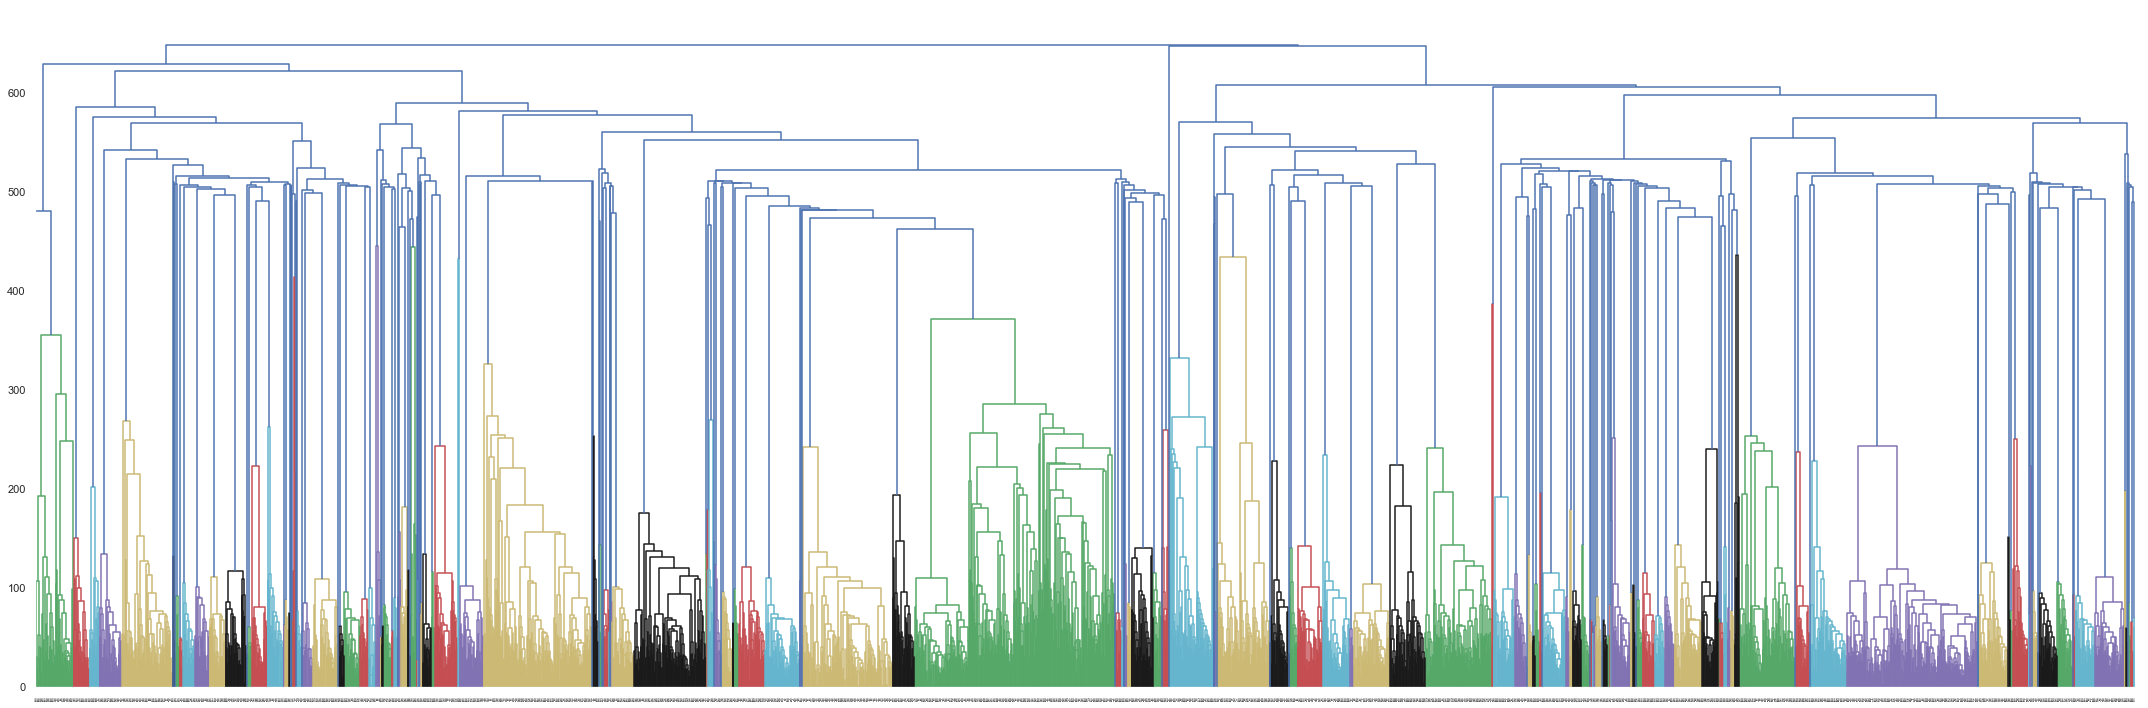

In [91]:
X = gprofs_standard_df.set_index('gname')
link_mat = sp.cluster.hierarchy.linkage(X, method='ward')  # also worth trying method='centroid' and method='complete'

fig = plt.figure(figsize=(960, 320))
dn = sp.cluster.hierarchy.dendrogram(link_mat, leaf_rotation=90, leaf_font_size=3)
plt.tight_layout()
fig.set_size_inches(120,40) 
plt.tight_layout()
plt.savefig('dendrogram1.png', bbox_inches='tight')

### Try initial clustering to determine number of top-level clusters we should specify

3
3
Metrics for k=3:
   Inertia: 299
   Silhouette: 0.868
   ARI: 1.0


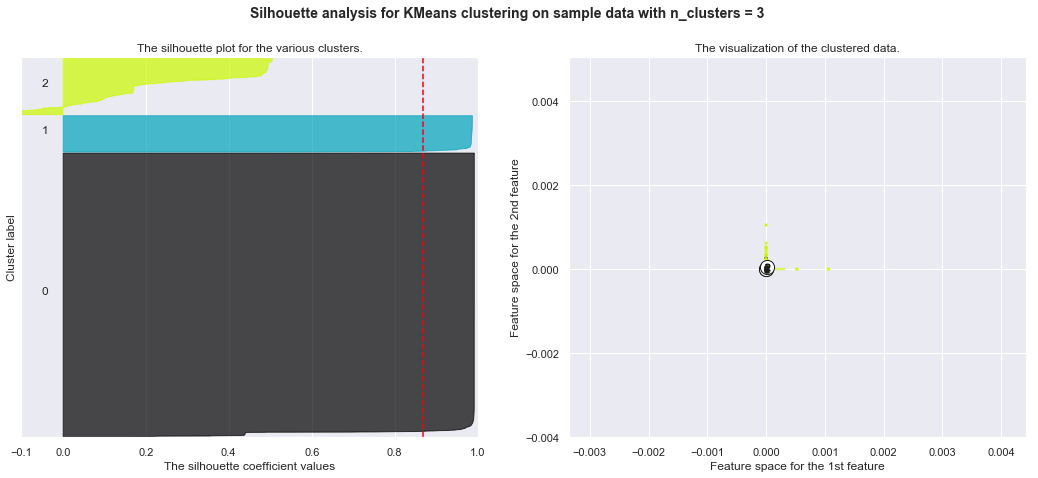

elapsed scaling time: 0.1 minutes

4
4
Metrics for k=4:
   Inertia: 160
   Silhouette: 0.903
   ARI: 1.0


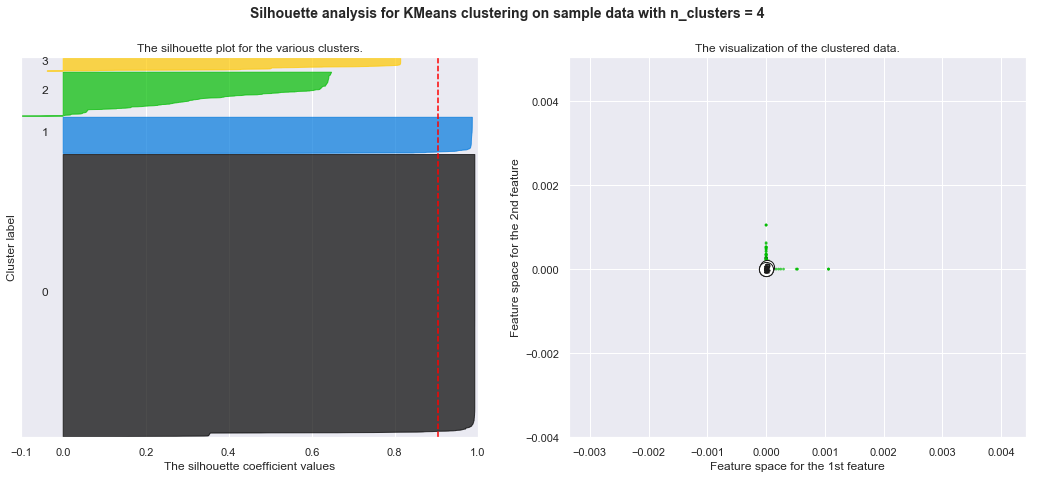

elapsed scaling time: 0.1 minutes

5
5
Metrics for k=5:
   Inertia: 114
   Silhouette: 0.913
   ARI: 1.0


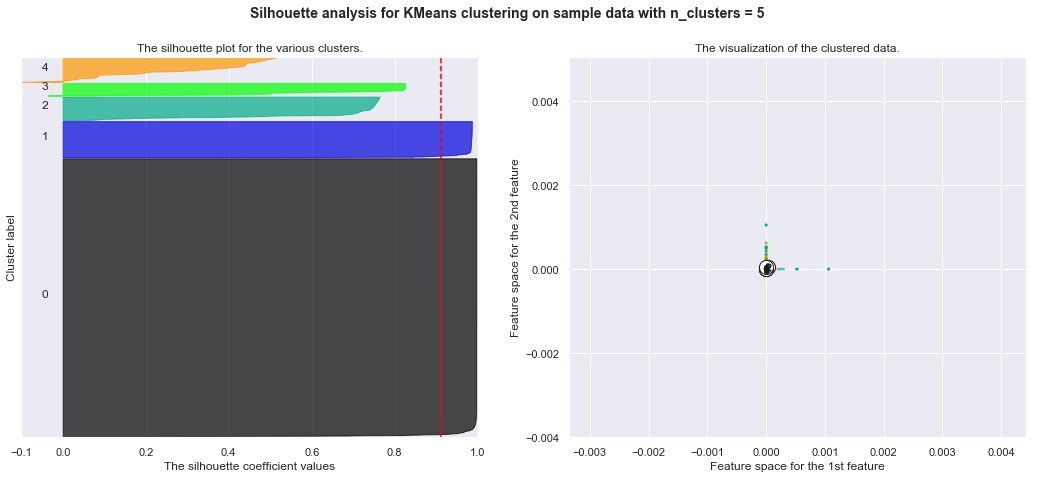

elapsed scaling time: 0.1 minutes

6
6
Metrics for k=6:
   Inertia: 90
   Silhouette: 0.923
   ARI: 1.0


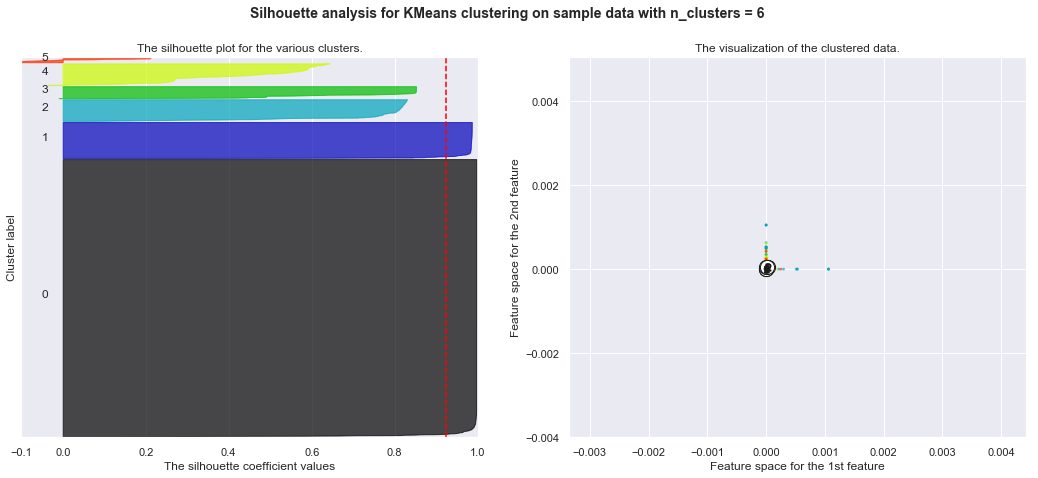

elapsed scaling time: 0.1 minutes

8
8
Metrics for k=8:
   Inertia: 65
   Silhouette: 0.929
   ARI: 0.9998675944378832


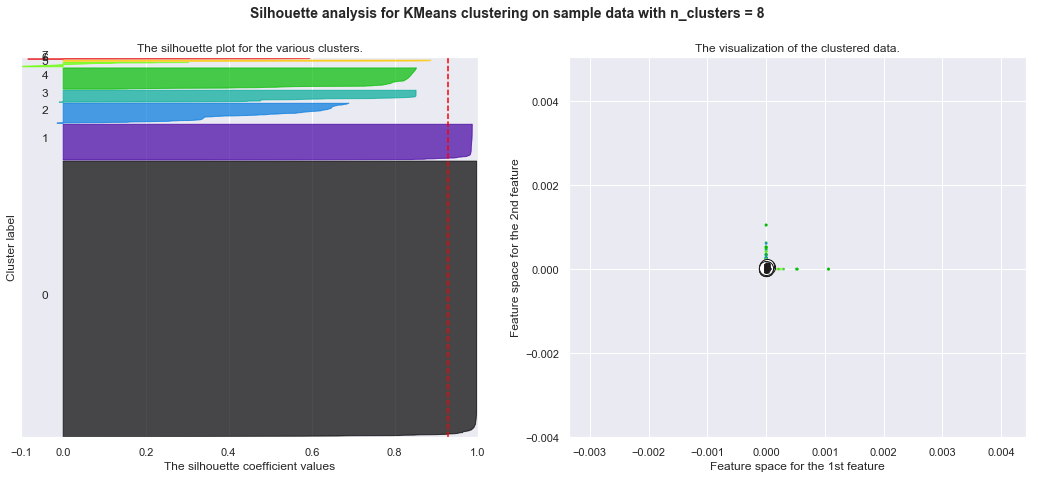

elapsed scaling time: 0.1 minutes

10
10
Metrics for k=10:
   Inertia: 49
   Silhouette: 0.931
   ARI: 0.9996766350176272


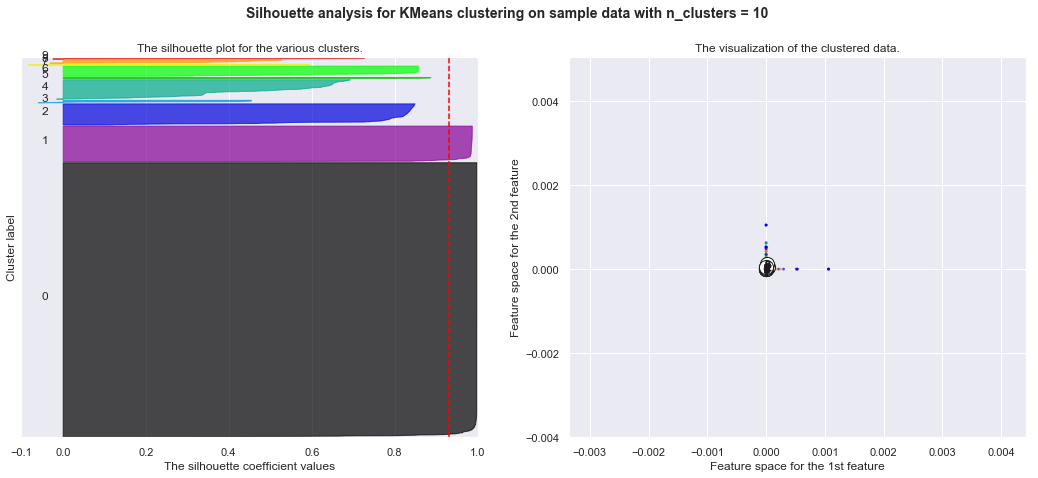

elapsed scaling time: 0.1 minutes

12
12
Metrics for k=12:
   Inertia: 41
   Silhouette: 0.92
   ARI: 0.9997810827937222


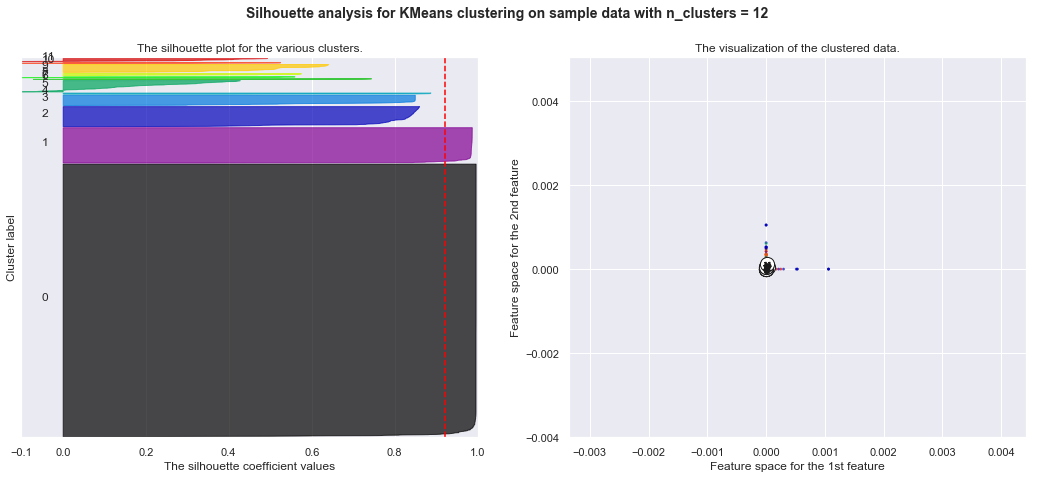

elapsed scaling time: 0.1 minutes

14
14
Metrics for k=14:
   Inertia: 35
   Silhouette: 0.923
   ARI: 0.99925639701081


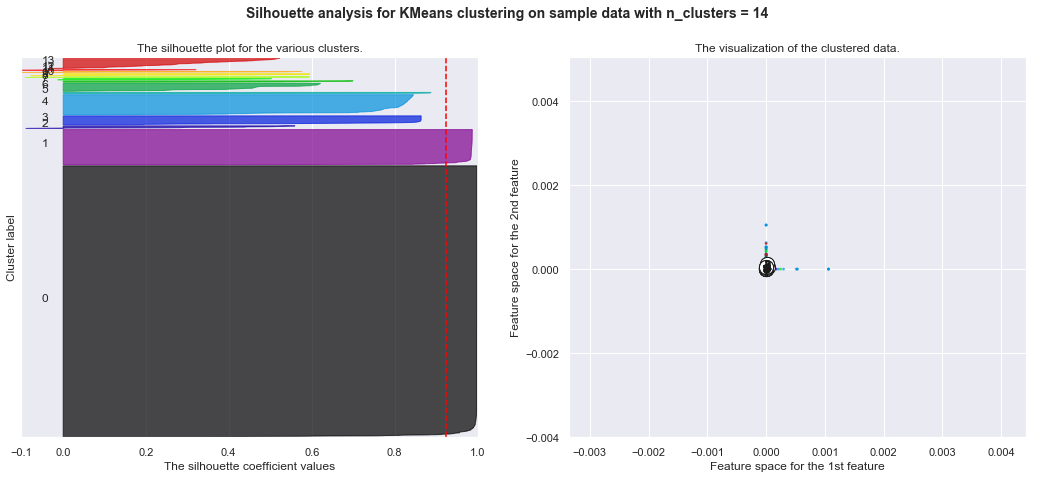

elapsed scaling time: 0.1 minutes



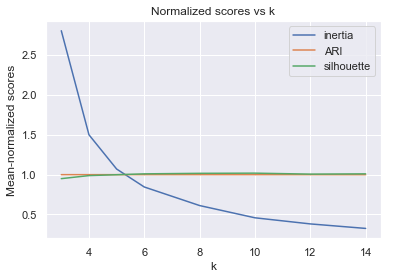

In [293]:
from sklearn.cluster import KMeans
from show_silhouettes import show_silhouettes # custom sklearn-example-based function in same directory
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples

inertia_scores = []
ari_scores = []
silhouettes = []
for k in [3, 4, 5, 6, 8, 10, 12, 14]:
    start=time()
    knn = KMeans(n_clusters=k, random_state=11)
    cluster_labels = knn.fit_predict(gprofs_normed_df.drop('gname', axis=1))
    knn2 = KMeans(n_clusters=k, random_state=13)
    cluster_labels2 = knn2.fit_predict(gprofs_normed_df.drop('gname', axis=1))
    ari = adjusted_rand_score(cluster_labels, cluster_labels2)
    ari_scores.append(ari)
    inertia_scores.append(knn.inertia_)
    silhouette = round(silhouette_score(gprofs_normed_df.drop('gname', axis=1), cluster_labels), 3)
    silhouettes.append(silhouette)
    print("Metrics for k={}:".format(k))
    print("   Inertia:", int(round(knn.inertia_)))
    print("   Silhouette:", silhouette)
    print("   ARI:", ari)
    show_silhouettes(gprofs_normed_df.drop('gname', axis=1), knn, k, cluster_labels, show_av_score=False)
    print('elapsed scaling time:', round((time()-start)/60, 1), "minutes\n")
    
plt.plot([3, 4, 5, 6, 8, 10, 12, 14], inertia_scores / np.mean(inertia_scores), label='inertia')
plt.plot([3, 4, 5, 6, 8, 10, 12, 14], ari_scores / np.mean(ari_scores), label='ARI')
plt.plot([3, 4, 5, 6, 8, 10, 12, 14], silhouettes / np.mean(silhouettes), label='silhouette')
plt.title('Normalized scores vs k')
plt.xlabel("k")
plt.ylabel('Mean-normalized scores')
plt.legend()
plt.show()

# Scratch -- ignore

Improvements to hier_classify to actually store all the results using the index to keep track of alignment, rather than the rather hacky method above where accuracies are calculated on-the-spot and then averaged

In [313]:
def hier_classify(X_train, X_test, y_train, y_test, max_tier=10):
    start = time()    
    progress = [0, len(X_test)]
    pred_results = y_test.copy()
    pred_results[:] = 0
    
    def classify(X_train, X_test, y_train, y_test, pred_results, progress, tier=1):
        '''accudict should be an empty dict; it will store labeling accuracies for each tier'''

        dtc = DecisionTreeClassifier()

        # base case:
        if tier > max_tier or X_train.shape[0] < 50:
            y_temp_train = y_train['gname']
            y_temp_test = y_test['gname']
            dtc.fit(X_train, y_temp_train)
            y_train_pred = dtc.predict(X_train)
            y_test_pred = dtc.predict(X_test)
            pred_results.loc[y_test_temp.index, 'gname'] = y_test_pred
            progress[0] += len(y_test)
            print('Predicted', round(100* progress[0] / progress[1]), '% of test rows', end='\r') 
            return pd.concat([X_test.eventid, pd.Series(y_test_pred)], axis=1)

        # recursive case:       
        else:
            # predict next level of tiers beneath the present tier label
            y_train_temp = y_train['cluster_label_'+str(tier)]
            y_test_temp = y_test['cluster_label_'+str(tier)]
            dtc.fit(X_train, y_train_temp)
            y_train_pred = dtc.predict(X_train)
            y_test_pred = dtc.predict(X_test)
            
            pred_results.loc[y_test_temp.index, ['cluster_label_'+str(tier)]]
            # log tier-label accuracy in accudict
            accudict[tier].append( sum(y_test_pred==y_test_temp) / len(y_test_temp) )

            # get target predictions from lower levels
            test_preds = None
            for label in np.unique(y_test_pred):
                train_rows = (y_train['cluster_label_'+str(tier)]==label).reset_index(drop=True)
                test_rows = (y_test['cluster_label_'+str(tier)]==label).reset_index(drop=True)
                if sum(test_rows) < 1:
                    continue
                test_preds_temp = classify(
                    X_train[train_rows],
                    X_test[test_rows],
                    y_train[train_rows],
                    y_test[test_rows],
                    pred_results,
                    progress,
                    tier+1 )
                if test_preds is None:
                    test_preds = pd.DataFrame(test_preds_temp)
                else:
                    test_preds = pd.concat([test_preds, pd.DataFrame(test_preds_temp)], axis=0)

            return test_preds

    test_preds = classify(
        X_train,
        X_test,
        y_train,
        y_test,
        accudict,
        progress,
        1 )
    
    # sort test preds to original order
    test_preds = pd.merge(pd.DataFrame(X_test.eventid), test_preds, on='eventid', how='left')[0]
    
    # print results
    print('\nUnweighted average labeling accuracy for each tier:')
    for i in range(1,max_tier+1):
        print("  Tier {}: {}".format(
            i, 
            round(np.mean(accudict[i]), 3)) )  
    accuracy = round(sum(test_preds==y_test.gname.reset_index(drop=True))/len(test_preds), 3)
    print('\nTest accuracy:', accuracy)
    print("elapsed time:", round((time()-start)/60, 1), 'minutes')
    return test_preds

In [125]:
test_df = pd.DataFrame()
test_df['a'] = [1,2,3,4]
test_df['b'] = [5,6,7,8]
test_df['c'] = [1,2,'s','t']
d = {'a':5}
d2 = {'b':6}
test_df['d'] = [5,2,d2,d2]
test_df

,a,b,c,d
0,1,5,1,5
1,2,6,2,2
2,3,7,s,{'b': 6}
3,4,8,t,{'b': 6}


In [300]:
# show countries with null latitudes:
gtd_filled_df[gtd_filled_df.longitude.isnull()].gname.isnull().sum()

0

In [271]:
# search for country:
countries = np.unique([c for c in gtd_df.country_txt.values if "Cocos" in c])
gtd_df.country_txt.value_counts()[countries]

Series([], Name: country_txt, dtype: int64)

In [48]:
# show remaining null counts after filling everything but long/lat:
nulls = gtd_filled_df.isnull().sum()
for col in gtd_filled_df.columns:
    if nulls[col] > 0:
        print(col, nulls[col])

latitude 4550
longitude 4551


In [ ]:
# CORE COLUMNS - most likely to be determinative of the group responsible
core_cols = [
    'iyear'
    'country_txt'
    'city'
    'latitude'
    'longitude'
    'suicide'
    'natlty1_txt'
    'attacktype1'
    'targtype1_txt'
    'targsubtype1_txt'
    'weaptype1_txt'
    'weapsubtype1_txt'
    'ishostkid'
    'nhostkid'
    'INT_LOG'
    'INT_IDEO'
    'INT_MISC'
]

In [2]:
gprofs_standard_df.head()

,gname,coordinates_are_approx_mean,has_second_attacktype_mean,is_related_mean,country_txt_Afghanistan_mean,country_txt_Albania_mean,country_txt_Algeria_mean,country_txt_Andorra_mean,country_txt_Angola_mean,country_txt_Antigua and Barbuda_mean,...,ransompaidus_median,ransompaidus_max,ransompaidus_var,total_null_ct_median,total_null_ct_max,total_null_ct_var,n_unreleased_median,n_unreleased_max,n_unreleased_var,attacks_count
0,1 May,1.240788,-0.707220,1.709477,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,0.540050,0.728531,-0.387881,-0.102607,-0.136135,-0.058195,-6.058415e+205
1,14 K Triad,-0.681998,-0.707220,9.344090,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,-0.861709,-1.006402,-0.325627,-0.102607,-0.136135,-0.058195,-8.081159e+205
2,14 March Coalition,-0.681998,21.019188,-1.066746,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,-1.842940,-2.163023,-0.262495,-0.102607,-0.136135,-0.058195,-9.092532e+205
3,14th of December Command,-0.681998,-0.707220,-1.066746,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,0.820402,0.728531,-0.536983,-0.102607,-0.136135,-0.058195,-8.418284e+205
4,15th of September Liberation Legion,-0.681998,-0.707220,-1.066746,-0.534501,-0.100915,-0.587037,-0.100915,-0.293724,0.0,...,-0.014094,-0.020084,-0.017026,0.399874,0.150220,-0.262495,-0.102607,-0.136135,-0.058195,-9.092532e+205


### Abortive graphviz attempt (works, but needs a lot of parameter fiddling to make this giant file readable)

In [152]:
import graphviz
from sklearn.tree import export_graphviz

tree_viz = export_graphviz(dtc, out_file=None)
graph = graphviz.Source(tree_viz)

In [153]:
graph.render()

'Source.gv.pdf'

In [155]:
del tree_viz, graph

In [158]:
dummy_df.columns[280]

'targtype1_txt_Business'

In [ ]:
# REPLOT the decision tree so it's interpretable (look at the sklearn examples)
# also maybe... https://bigml.com/user/ashikiar/gallery/model/52696f10035d0737bd0312e5

# CATNB PACKAGE
# offer fuzzy-prediction option with adding noise to avoid overfitting / false assumptions ??

In [1]:
# FULL RELOAD
# - core imports & datasets (gtd_df, gtd_prepped_df, gtd_filled_df)
# - core model imports
# - quick_test_model
# - dummy_df (dummy-version of filled_df with gtd attached - DOES NOT INCLUDE UNATTRIBUTED ATTACKS)


# CORE IMPORTS
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
%matplotlib inline
sns.set()

# import auto-reloader
%load_ext autoreload
%autoreload 2

# MODEL IMPORTS
from sklearn.model_selection import train_test_split
import warnings
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer

# MAIN DATA RELOAD:
from scripts import load_and_clean, quick_test_model, compile_profiles
gtd_raw_df = pd.read_csv('globalterrorismdb_0718dist.csv', low_memory=False)
gtd_df, gtd_prepped_df, gtd_filled_df = load_and_clean(gtd_raw_df)

dummy_df = pd.get_dummies(gtd_filled_df.drop('gname', axis=1))
dummy_df = pd.concat([dummy_df, gtd_filled_df.gname], axis=1)
dummy_df = dummy_df[dummy_df.gname!='Unknown']

gprofs_standard_df = compile_profiles(dummy_df, StandardScaler())
gprofs_robust_df = compile_profiles(dummy_df, RobustScaler())
gprofs_normed_df = compile_profiles(dummy_df, Normalizer())